# 🎯 Jupiter Store – Personalized Reward Recommendation System (EDA Phase)

---

## 🧠 Problem Context

Jupiter is building a **contextual and personalized reward recommendation system** to be integrated into the **Jupiter Store**. The goal is to move beyond static, one-size-fits-all rewards and instead tailor offers based on **user behavior, interests, and timing**.

### 🎯 Use Cases:
- A user frequently booking movie tickets via BookMyShow should receive **BookMyShow rewards**.
- A user ordering on Swiggy every Friday night should receive a **Swiggy reward by Thursday evening**.
- A user who spends heavily on Uber should receive **Uber Cash or ride coupons**.
- A user shopping at Big Bazaar regularly should get grocery store coupons.

To support this, we use **transactional data** (e.g., from AA/ADA sources) to understand user behavior and build **user personas** (e.g., foodies, movie-goers, travelers). These personas are then mapped to relevant merchant rewards using machine learning models.

This system will be deployed within the **Jupiter App's Store**, with future plans to trigger recommendations through **Push or WhatsApp API** in real-time based on behavioral context.

---

## 📂 Dataset Used for EDA
2
**File:** `transactions.csv` (121,903 records)

The dataset contains user transactions from **AA** and **Internal Transaction Sources** with the following key columns:

| Column Name | Description |
|-------------|-------------|
| `user_id` | Unique identifier of the user |
| `transactiondatetime` | Timestamp of the transaction |
| `merchant` | Name of the merchant |
| `transactionamount` | Amount spent in INR |
| `jupiterfinegraincategory` | Fine-grained transaction category |
| `jupiter_coarsegrain_category` | Broad transaction category |
| `usercategory` | User-defined category |
| `appcategory` | App-defined category |
| `bankname` | Bank used for transaction |
| `transactionchannel` | Channel (UPI, NEFT, etc.) |
| `payee` | Merchant/payee name |
| `product` | Data source (ADA, etc.) |
| `creditdebitindicator` | Transaction direction |

---

## 🔍 EDA Objectives

This phase will perform **Exploratory Data Analysis (EDA)** to uncover:

1. **Dataset Structure & Quality**
   - Data completeness and missing values
   - Transaction volume and time range
   - Data quality issues

2. **Merchant Analysis**
   - Top merchants by transaction volume and frequency
   - Merchant category distribution
   - Merchant name normalization needs

3. **User Behavior Patterns**
   - User transaction frequency and spending patterns
   - User-merchant affinity mapping
   - Spending intensity per user

4. **Temporal Patterns**
   - Transaction trends over time (day-of-week, hour-of-day)
   - Seasonal patterns for different merchants
   - Peak activity times

5. **Category Analysis**
   - Category preference by users
   - Category-wise spending patterns
   - Cross-category behavior

6. **Recommendation System Insights**
   - User-merchant interaction matrix sparsity
   - Collaborative filtering feasibility
   - Persona identification signals

7. **Data Preprocessing Needs**
   - Merchant name standardization
   - Outlier detection
   - Feature engineering opportunities

This analysis will inform the design of machine learning models for personalized reward recommendations.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
import pandasql as ps

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print("📊 Ready for EDA analysis")


✅ Libraries imported successfully!
📊 Ready for EDA analysis


In [2]:
# Core data science libraries
!pip install -q pandas numpy matplotlib seaborn plotly
!pip install -q scikit-learn scipy
!pip install -q wordcloud
!pip install -q pandasql

In [3]:
# Load the transaction data

try:
    df = pd.read_csv('transactions.csv')
    print(f"✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape[0]:,} transactions with {df.shape[1]} features")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    df = None


✅ Data loaded successfully!
📊 Dataset shape: 12,192 transactions with 33 features


In [4]:
# Display basic information about the dataset
print("🔍 Dataset Overview")
print("=" * 50)

if df is not None:
    # Basic info
    print(f"📊 Shape: {df.shape}")
    print(f"🕐 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"📅 Date range: {df['transactiondatetime'].min()} to {df['transactiondatetime'].max()}")
    
    # Display first few rows
    print("\n📋 First 5 rows:")
    display(df.head())
    
    # Column information
    print("\n📝 Column Information:")
    print(df.info())
else:
    print("❌ No data to display")


🔍 Dataset Overview
📊 Shape: (12192, 33)
🕐 Memory usage: 23.34 MB
📅 Date range: 2025-01-01T00:00:00.000Z to 2025-03-21T21:25:01.000Z

📋 First 5 rows:


,flag,num,mmuuid,user_id,transactiondatetime,transactionstatus,jupiterfinegraincategory,jupiter_coarsegrain_category,usercategory,appcategory,bankname,transactionchannel,transactiontype,payer,payee,mcccode,merchant,product,payeeparticulars,payerparticulars,adaparticulars,creditdebitindicator,jupiter_transaction_id,transactionamount,reconstatus,accountid,publishtime,tags,useractivity_hasupdatedcategory,categorymetadata_source,counterpartymetadata_source,rn,eccparticulars
0,mm_enriched,2,34681ffa5ff5e1f8f19a48cf187028b3,ad829bcd-77c1-4fe9-9932-102531fbcc24,2025-03-10T12:07:20.000Z,SUCCESS,drinks,food & drinks,food & drinks,food & drinks,HDFC Bank,UPI,UPI,Self,mathin tea point,0,NaN,ADA,{},{},"{\n ""reference"" : ""0000506934753998"",\n ""sou...",DEBIT,NaN,35.00,RECONCILIATION_SUCCESSFUL,a9a08ff6569d410c70f4d5cb62f3f985,2025-07-23T22:48:55.478Z,[],False,CP_PRECISION_WORD_CLOUD,MM_INGESTION,1,NaN
1,mm_enriched,2,9297613531d637f118db0172bb5af166,dbae6fc8-c423-411a-86e2-4b69f09d2c2c,2025-02-21T22:06:37.000Z,SUCCESS,digital subscriptions,entertainment,entertainment,entertainment,FEDERAL BANK,UPI,UPI,Self,Aha,0,NaN,ADA,{},{},"{\n ""reference"" : ""278213188394/Payment from ...",DEBIT,NaN,35000.00,RECONCILIATION_SUCCESSFUL,ebb0541cd7b5146885d164770d60b39e,2025-07-23T06:09:52.343Z,[],False,ANNOTATED_MERCHANTS,VPA_NORMALIZATION,1,NaN
2,mm_enriched,2,2f28da58868e5cc47647090c10525a64,c58a00fe-41c3-4746-92b0-58582afea3e0,2025-02-01T14:33:20.000Z,SUCCESS,person name,uncategorised,uncategorised,uncategorised,STATE BANK OF INDIA,UPI,UPI,Self,KAGITALA,0,KAGITALA,ADA,{},{},"{\n ""reference"" : """",\n ""source"" : ""FINVU"",\...",DEBIT,NaN,110.00,RECONCILIATION_SUCCESSFUL,50c2e1b448d3a538a9742fa9e96ddb23,2025-07-23T18:11:52.441Z,[],False,PERSON_MODEL,MM_INGESTION,1,NaN
3,mm_enriched,2,f8e6583aeec9f50389bb46a4763258aa,a708954a-6123-4bcd-afeb-900702c56eec,2025-01-01T03:03:17.000Z,SUCCESS,uncategorised,uncategorised,uncategorised,uncategorised,ICICI Bank,UPI,UPI,Self,boism-880583701,0,NaN,ADA,{},{},"{\n ""reference"" : """",\n ""source"" : ""FINVU"",\...",DEBIT,NaN,200.00,RECONCILIATION_SUCCESSFUL,ac8dcd28f01285d3271c948f09056f04,2025-07-23T10:55:21.607Z,[],False,NaN,MM_INGESTION,1,NaN
4,mm_enriched,2,e297240d794f37253c174a88ea0c3292,3be1aa7e-4750-4900-8f18-0b7de28686f3,2025-03-05T23:32:58.000Z,SUCCESS,bills,bills & utilities,bills & utilities,bills & utilities,IDFC FIRST BANK,UPI,UPI,Self,Payment from PhonePe,0,Payment from PhonePe,ADA,{},{},"{\n ""reference"" : ""MOB"",\n ""source"" : ""FINVU...",DEBIT,NaN,5000.00,RECONCILIATION_SUCCESSFUL,ef993d7daa5c87b3f666ed43097f77f4,2025-07-23T21:53:42.776Z,[],False,CLASSIFIER_CACHE,MM_INGESTION,1,NaN



📝 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12192 entries, 0 to 12191
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   flag                             12192 non-null  object 
 1   num                              12192 non-null  int64  
 2   mmuuid                           12192 non-null  object 
 3   user_id                          12192 non-null  object 
 4   transactiondatetime              12192 non-null  object 
 5   transactionstatus                12192 non-null  object 
 6   jupiterfinegraincategory         12192 non-null  object 
 7   jupiter_coarsegrain_category     12192 non-null  object 
 8   usercategory                     12192 non-null  object 
 9   appcategory                      12192 non-null  object 
 10  bankname                         12192 non-null  object 
 11  transactionchannel               12192 non-null  object 


In [5]:
# Data preprocessing and quality checks
print("🧹 Data Quality Analysis")
print("=" * 50)

if df is not None:
    # Convert datetime column
    df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])
    
    # Convert transaction amount to numeric
    df['transactionamount'] = pd.to_numeric(df['transactionamount'], errors='coerce')
    
    # Remove duplicates if any
    initial_shape = df.shape[0]
    df = df.drop_duplicates()
    duplicates_removed = initial_shape - df.shape[0]
    
    print(f"🔄 Duplicates removed: {duplicates_removed:,}")
    
    # Check for missing values
    print("\n🔍 Missing Values Analysis:")
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percentage
    })
    
    # Only show columns with missing values
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("✅ No missing values found!")
    
    # Filter for successful transactions and debit transactions (actual spending)
    df_clean = df[
        (df['transactionstatus'] == 'SUCCESS') & 
        (df['creditdebitindicator'] == 'DEBIT') &
        (df['transactionamount'] > 0)
    ].copy()
    
    print(f"\n📊 After filtering (successful debit transactions): {df_clean.shape[0]:,} transactions")
    print(f"📉 Reduction: {((df.shape[0] - df_clean.shape[0]) / df.shape[0] * 100):.1f}%")
    
    # Use cleaned data for analysis
    df = df_clean.copy()
    
else:
    print("❌ No data to analyze")


🧹 Data Quality Analysis
🔄 Duplicates removed: 0

🔍 Missing Values Analysis:
                             Missing Count  Percentage
eccparticulars                       12192      100.00
jupiter_transaction_id               12192      100.00
merchant                              9142       74.98
categorymetadata_source               4222       34.63
counterpartymetadata_source              2        0.02
payee                                    1        0.01

📊 After filtering (successful debit transactions): 12,189 transactions
📉 Reduction: 0.0%


## 🏪 Comprehensive Merchant Analysis for Recommendation Systems

### Problem Statement
Merchant analysis forms the backbone of our personalized reward recommendation system. Understanding merchant patterns helps us:
- **Identify Partnership Opportunities**: Find high-value merchants for reward collaborations
- **User-Merchant Affinity Mapping**: Understand which merchants users prefer and frequent
- **Reward Targeting**: Match users to relevant merchant-specific offers
- **Market Concentration**: Analyze merchant distribution and competition landscape

### Key Questions to Answer
1. **Which merchants have the highest transaction volumes and user penetration?**
2. **How concentrated is the merchant market (few merchants vs many)?**
3. **What are the spending patterns across different merchant categories?**
4. **Which merchants show the best potential for reward partnerships?**

### Approach
1. **Data Cleaning**: Standardize merchant names for accurate analysis
2. **Volume Analysis**: Analyze transaction counts, values, and user engagement
3. **Market Concentration**: Understand distribution of merchant power
4. **Partnership Scoring**: Rank merchants by recommendation system value


In [6]:
# Step 1: Merchant Data Preparation and Comprehensive Analysis
print("🏪 Detailed Merchant Analysis for Recommendation Systems")
print("=" * 65)

if df is not None and len(df) > 0:
    print("\n🔧 Step 1: Merchant Data Cleaning and Standardization")
    print("Preparing merchant data for accurate analysis...")
    
    # Create unified merchant field - prioritize 'payee' over 'merchant'
    df['merchant_name'] = df['payee'].fillna(df['merchant']).fillna('Unknown')
    
    # Advanced merchant name cleaning for better matching
    def clean_merchant_name(name):
        """
        Standardize merchant names to improve recommendation accuracy
        Removes common business suffixes and standardizes formatting
        """
        if pd.isna(name) or name == 'Unknown':
            return 'Unknown'
        # Convert to lowercase and strip whitespace
        cleaned = str(name).lower().strip()
        # Remove common business suffixes and prefixes
        cleaned = re.sub(r'\b(ltd|limited|pvt|private|inc|corp|corporation|co)\b\.?', '', cleaned)
        cleaned = re.sub(r'\b(the|a|an)\b', '', cleaned)
        # Remove extra whitespace and normalize
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        return cleaned
    
    print("🧹 Applying merchant name standardization...")
    df['merchant_clean'] = df['merchant_name'].apply(clean_merchant_name)
    
    print("\n📊 Step 2: Computing Comprehensive Merchant Metrics")
    print("Calculating partnership and recommendation value scores...")
    
    # Comprehensive merchant statistics for recommendation system
    merchant_stats = df.groupby('merchant_clean').agg({
        'transactionamount': ['count', 'sum', 'mean', 'median', 'std'],
        'user_id': 'nunique',
        'transactiondatetime': ['min', 'max']
    }).round(2)
    
    merchant_stats.columns = ['txn_count', 'total_value', 'avg_amount', 'median_amount', 
                             'amount_std', 'unique_users', 'first_txn', 'last_txn']
    
    # Calculate recommendation system metrics
    merchant_stats['days_active'] = (merchant_stats['last_txn'] - merchant_stats['first_txn']).dt.days + 1
    merchant_stats['txn_per_day'] = merchant_stats['txn_count'] / merchant_stats['days_active']
    merchant_stats['avg_users_per_day'] = merchant_stats['unique_users'] / merchant_stats['days_active']
    merchant_stats['user_penetration'] = (merchant_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    merchant_stats['avg_txn_per_user'] = (merchant_stats['txn_count'] / merchant_stats['unique_users']).round(2)
    merchant_stats['value_per_user'] = (merchant_stats['total_value'] / merchant_stats['unique_users']).round(0)
    
    print(f"✅ Merchant analysis complete!")
    print(f"🏪 Total unique merchants: {len(merchant_stats):,}")
    print(f"💰 Total transaction value: ₹{df['transactionamount'].sum():,.0f}")
    print(f"📊 Average transactions per merchant: {merchant_stats['txn_count'].mean():.1f}")
    print(f"📈 Median transactions per merchant: {merchant_stats['txn_count'].median():.1f}")
    
    print("\n🏆 TOP 20 MERCHANTS BY TRANSACTION COUNT (Partnership Priority):")
    top_by_count = merchant_stats.sort_values('txn_count', ascending=False).head(20)
    display(top_by_count[['txn_count', 'total_value', 'avg_amount', 'unique_users', 'user_penetration']])
    
    print("\n💎 TOP 20 MERCHANTS BY TOTAL TRANSACTION VALUE (Revenue Impact):")
    top_by_value = merchant_stats.sort_values('total_value', ascending=False).head(20)
    display(top_by_value[['total_value', 'txn_count', 'avg_amount', 'unique_users', 'user_penetration']])
    
    print("\n💸 TOP 20 MERCHANTS BY AVERAGE TRANSACTION AMOUNT (High-Value Segments):")
    top_by_avg = merchant_stats.sort_values('avg_amount', ascending=False).head(20)
    display(top_by_avg[['avg_amount', 'txn_count', 'total_value', 'unique_users', 'user_penetration']])
    
    print("\n👥 TOP 20 MERCHANTS BY USER PENETRATION (Market Reach):")
    top_by_penetration = merchant_stats.sort_values('user_penetration', ascending=False).head(20)
    display(top_by_penetration[['user_penetration', 'unique_users', 'txn_count', 'avg_txn_per_user', 'value_per_user']])
    
else:
    print("❌ No data available for merchant analysis")


🏪 Detailed Merchant Analysis for Recommendation Systems

🔧 Step 1: Merchant Data Cleaning and Standardization
Preparing merchant data for accurate analysis...
🧹 Applying merchant name standardization...

📊 Step 2: Computing Comprehensive Merchant Metrics
Calculating partnership and recommendation value scores...
✅ Merchant analysis complete!
🏪 Total unique merchants: 8,617
💰 Total transaction value: ₹37,141,532
📊 Average transactions per merchant: 1.4
📈 Median transactions per merchant: 1.0

🏆 TOP 20 MERCHANTS BY TRANSACTION COUNT (Partnership Priority):


,txn_count,total_value,avg_amount,unique_users,user_penetration
merchant_clean,,,,,
cred club,148,2733884.61,18472.19,65,8.41
swiggy,77,22358.00,290.36,38,4.92
zomato,69,25692.28,372.35,40,5.17
payment from phonepe,59,242934.98,4117.54,9,1.16
**.club@axisb,45,357482.33,7944.05,21,2.72
**26953@ybl,30,530.00,17.67,1,0.13
cred,29,213405.20,7358.80,25,3.23
amazon pay,29,17719.39,611.01,22,2.85
blinkit,28,12739.00,454.96,22,2.85



💎 TOP 20 MERCHANTS BY TOTAL TRANSACTION VALUE (Revenue Impact):


,total_value,txn_count,avg_amount,unique_users,user_penetration
merchant_clean,,,,,
cred club,2733884.61,148,18472.19,65,8.41
eaz8198555,1900000.00,1,1900000.00,1,0.13
pravudutt,1075000.00,1,1075000.00,1,0.13
sagar tar,550000.00,1,550000.00,1,0.13
sm vengamamba f,454999.00,2,227499.50,1,0.13
anilkumar,405000.00,4,101250.00,1,0.13
credloan,389508.00,1,389508.00,1,0.13
**.club@axisb,357482.33,45,7944.05,21,2.72
payoff source /c,329349.00,2,164674.50,2,0.26



💸 TOP 20 MERCHANTS BY AVERAGE TRANSACTION AMOUNT (High-Value Segments):


,avg_amount,txn_count,total_value,unique_users,user_penetration
merchant_clean,,,,,
eaz8198555,1900000.00,1,1900000.00,1,0.13
pravudutt,1075000.00,1,1075000.00,1,0.13
sagar tar,550000.00,1,550000.00,1,0.13
credloan,389508.00,1,389508.00,1,0.13
imtiyaz s shaikh,320000.00,1,320000.00,1,0.13
ib billpay dr-hdfcea-553583xxxxxx6005,310735.00,1,310735.00,1,0.13
sonu,300017.70,1,300017.70,1,0.13
mr. govardhan kumawat,300000.00,1,300000.00,1,0.13
satyanarayan gupta,300000.00,1,300000.00,1,0.13



👥 TOP 20 MERCHANTS BY USER PENETRATION (Market Reach):


,user_penetration,unique_users,txn_count,avg_txn_per_user,value_per_user
merchant_clean,,,,,
cred club,8.41,65,148,2.28,42060.00
zomato,5.17,40,69,1.72,642.00
swiggy,4.92,38,77,2.03,588.00
cred,3.23,25,29,1.16,8536.00
blinkit,2.85,22,28,1.27,579.00
amazon pay,2.85,22,29,1.32,805.00
**.club@axisb,2.72,21,45,2.14,17023.00
slabwise nmmb charges,2.59,20,26,1.30,49.00
phonepe,2.46,19,24,1.26,4762.00


📊 Step 3: Merchant Market Analysis and Partnership Insights

🎨 Creating comprehensive merchant distribution visualizations...


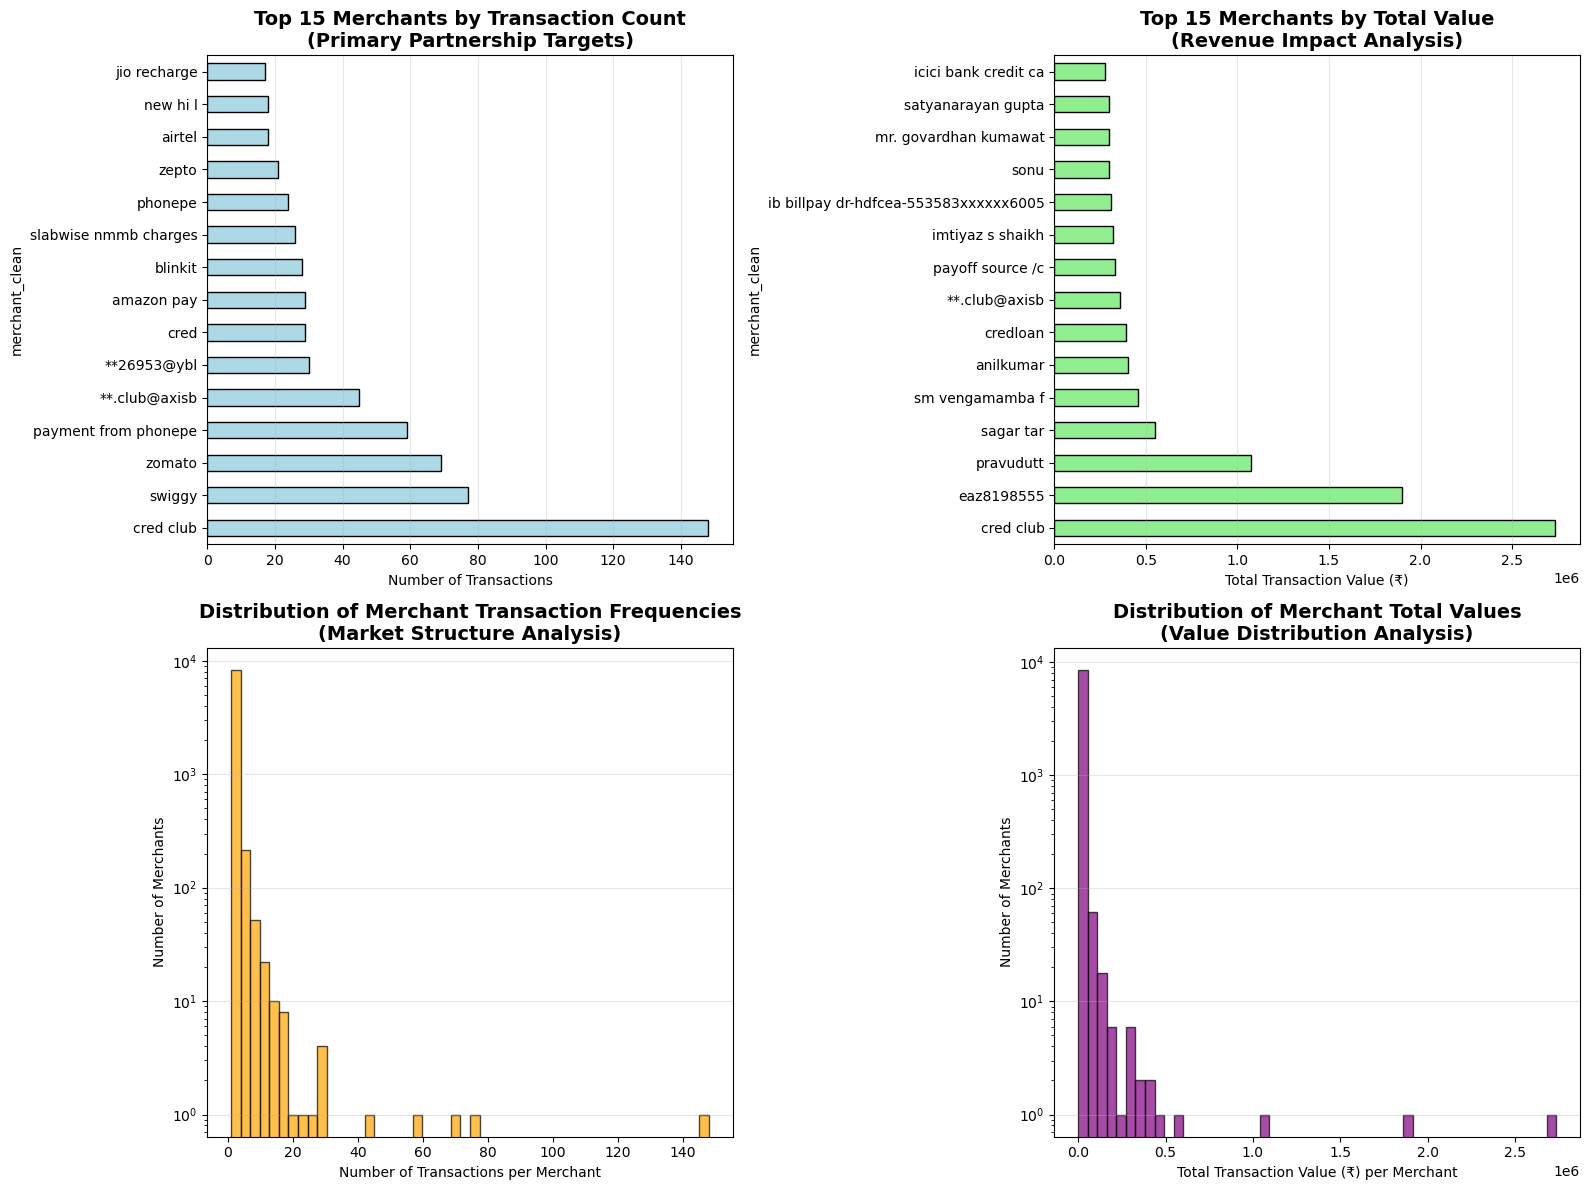


🎯 Merchant Market Concentration Analysis:
📊 Market Structure Insights:
   • Total merchants: 8,617
   • Merchants with >10 transactions: 41
   • Merchants with >100 transactions: 1

🏆 Top 1% Merchant Concentration (86 merchants):
   • Transaction share: 11.3% of all transactions
   • Value share: 14.8% of total transaction value

📈 Top 10% Merchant Concentration (861 merchants):
   • Transaction share: 31.5% of all transactions
   • Value share: 31.3% of total transaction value

💡 Recommendation System Strategy Implications:
📊 Fragmented Market Strategy:
   • Long-tail merchant partnerships crucial
   • Collaborative filtering more effective
   • User behavior patterns key to success

❄️ Cold Start Challenge Assessment:
   • Single-transaction merchants: 7,168 (83.2%)
   • Recommendation: High cold start complexity


In [7]:
# Step 3: Merchant Distribution Visualization and Market Concentration Analysis
print("📊 Step 3: Merchant Market Analysis and Partnership Insights")
print("=" * 60)

if df is not None and len(df) > 0:
    print("\n🎨 Creating comprehensive merchant distribution visualizations...")
    
    # Prepare data for visualizations
    top_merchants_count = df["merchant_clean"].value_counts()
    merchant_value = df.groupby("merchant_clean")["transactionamount"].sum().sort_values(ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Top merchants by transaction count (Partnership Priority)
    top_merchants_count.head(15).plot(kind="barh", ax=axes[0,0], color='lightblue', edgecolor='black')
    axes[0,0].set_title("Top 15 Merchants by Transaction Count\n(Primary Partnership Targets)", 
                       fontsize=14, fontweight="bold")
    axes[0,0].set_xlabel("Number of Transactions")
    axes[0,0].grid(axis='x', alpha=0.3)
    
    # Chart 2: Top merchants by transaction value (Revenue Impact)
    merchant_value.head(15).plot(kind="barh", ax=axes[0,1], color='lightgreen', edgecolor='black')
    axes[0,1].set_title("Top 15 Merchants by Total Value\n(Revenue Impact Analysis)", 
                       fontsize=14, fontweight="bold")
    axes[0,1].set_xlabel("Total Transaction Value (₹)")
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # Chart 3: Merchant frequency distribution (Long Tail Analysis)
    merchant_freq = df["merchant_clean"].value_counts()
    axes[1,0].hist(merchant_freq.values, bins=50, edgecolor="black", alpha=0.7, color='orange')
    axes[1,0].set_title("Distribution of Merchant Transaction Frequencies\n(Market Structure Analysis)", 
                       fontsize=14, fontweight="bold")
    axes[1,0].set_xlabel("Number of Transactions per Merchant")
    axes[1,0].set_ylabel("Number of Merchants")
    axes[1,0].set_yscale("log")
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Chart 4: Merchant value distribution (Value Concentration)
    merchant_values = df.groupby("merchant_clean")["transactionamount"].sum()
    axes[1,1].hist(merchant_values.values, bins=50, edgecolor="black", alpha=0.7, color='purple')
    axes[1,1].set_title("Distribution of Merchant Total Values\n(Value Distribution Analysis)", 
                       fontsize=14, fontweight="bold")
    axes[1,1].set_xlabel("Total Transaction Value (₹) per Merchant")
    axes[1,1].set_ylabel("Number of Merchants")
    axes[1,1].set_yscale("log")
    axes[1,1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Merchant Market Concentration Analysis:")
    print("=" * 50)
    
    # Market concentration insights for recommendation strategy
    total_transactions = len(df)
    total_value = df["transactionamount"].sum()
    
    # Calculate concentration metrics
    print(f"📊 Market Structure Insights:")
    print(f"   • Total merchants: {len(merchant_freq):,}")
    print(f"   • Merchants with >10 transactions: {(merchant_freq > 10).sum():,}")
    print(f"   • Merchants with >100 transactions: {(merchant_freq > 100).sum():,}")
    
    # Top 1% concentration analysis
    top_1_pct_count = max(1, merchant_freq.shape[0]//100)
    top_1_pct_merchants = merchant_freq.head(top_1_pct_count)
    top_1_pct_txns = top_1_pct_merchants.sum()
    top_1_pct_value = df[df["merchant_clean"].isin(top_1_pct_merchants.index)]["transactionamount"].sum()
    
    print(f"\n🏆 Top 1% Merchant Concentration ({top_1_pct_count} merchants):")
    print(f"   • Transaction share: {(top_1_pct_txns/total_transactions*100):.1f}% of all transactions")
    print(f"   • Value share: {(top_1_pct_value/total_value*100):.1f}% of total transaction value")
    
    # Top 10% concentration analysis
    top_10_pct_count = max(1, merchant_freq.shape[0]//10)
    top_10_pct_merchants = merchant_freq.head(top_10_pct_count)
    top_10_pct_txns = top_10_pct_merchants.sum()
    top_10_pct_value = df[df["merchant_clean"].isin(top_10_pct_merchants.index)]["transactionamount"].sum()
    
    print(f"\n📈 Top 10% Merchant Concentration ({top_10_pct_count} merchants):")
    print(f"   • Transaction share: {(top_10_pct_txns/total_transactions*100):.1f}% of all transactions")
    print(f"   • Value share: {(top_10_pct_value/total_value*100):.1f}% of total transaction value")
    
    # Partnership strategy recommendations
    print(f"\n💡 Recommendation System Strategy Implications:")
    print("=" * 50)
    
    concentration_ratio = top_10_pct_txns / total_transactions
    if concentration_ratio > 0.8:
        print("🎯 High Market Concentration Strategy:")
        print("   • Focus on top merchants for maximum impact")
        print("   • Prioritize partnerships with market leaders") 
        print("   • Content-based filtering suitable for concentrated market")
    elif concentration_ratio > 0.5:
        print("⚖️ Balanced Market Strategy:")
        print("   • Mix of top merchants and long-tail partnerships")
        print("   • Hybrid recommendation approach optimal")
        print("   • Category-based recommendations important")
    else:
        print("📊 Fragmented Market Strategy:")
        print("   • Long-tail merchant partnerships crucial")
        print("   • Collaborative filtering more effective")
        print("   • User behavior patterns key to success")
        
    # Cold start challenge assessment
    single_txn_merchants = (merchant_freq == 1).sum()
    print(f"\n❄️ Cold Start Challenge Assessment:")
    print(f"   • Single-transaction merchants: {single_txn_merchants:,} ({single_txn_merchants/len(merchant_freq)*100:.1f}%)")
    print(f"   • Recommendation: {'High' if single_txn_merchants/len(merchant_freq) > 0.5 else 'Moderate'} cold start complexity")

else:
    print("❌ No data available for merchant visualization")

## 👥 User Behavior Analysis


In [8]:
# User behavior analysis for personalization insights
print("👥 User Behavior Analysis")
print("=" * 50)

if df is not None and len(df) > 0:
    # Basic user statistics
    user_stats = df.groupby('user_id').agg({
        'transactionamount': ['count', 'sum', 'mean', 'std'],
        'merchant_clean': 'nunique',
        'transactiondatetime': ['min', 'max']
    }).round(2)
    
    user_stats.columns = ['txn_count', 'total_spent', 'avg_txn_amount', 'txn_amount_std', 
                         'unique_merchants', 'first_txn', 'last_txn']
    
    # Calculate transaction span in days
    user_stats['txn_span_days'] = (user_stats['last_txn'] - user_stats['first_txn']).dt.days
    user_stats['txn_frequency'] = user_stats['txn_count'] / (user_stats['txn_span_days'] + 1)
    
    print(f"\n📊 User Statistics Summary:")
    print(f"Total unique users: {len(user_stats):,}")
    print(f"Average transactions per user: {user_stats['txn_count'].mean():.1f}")
    print(f"Average spend per user: ₹{user_stats['total_spent'].mean():,.0f}")
    print(f"Average unique merchants per user: {user_stats['unique_merchants'].mean():.1f}")
    
    print(f"\n📈 User Behavior Distribution:")
    print(user_stats[['txn_count', 'total_spent', 'unique_merchants', 'txn_frequency']].describe())


👥 User Behavior Analysis

📊 User Statistics Summary:
Total unique users: 773
Average transactions per user: 15.8
Average spend per user: ₹48,049
Average unique merchants per user: 12.7

📈 User Behavior Distribution:
       txn_count  total_spent  unique_merchants  txn_frequency
count     773.00       773.00            773.00         773.00
mean       15.77     48048.55             12.69           0.38
std        14.72    152009.45             11.30           0.34
min         1.00         1.00              1.00           0.03
25%         5.00      3172.00              4.00           0.15
50%        11.00     16212.00              9.00           0.27
75%        23.00     51250.99             18.00           0.46
max       105.00   3618004.00             81.00           2.00


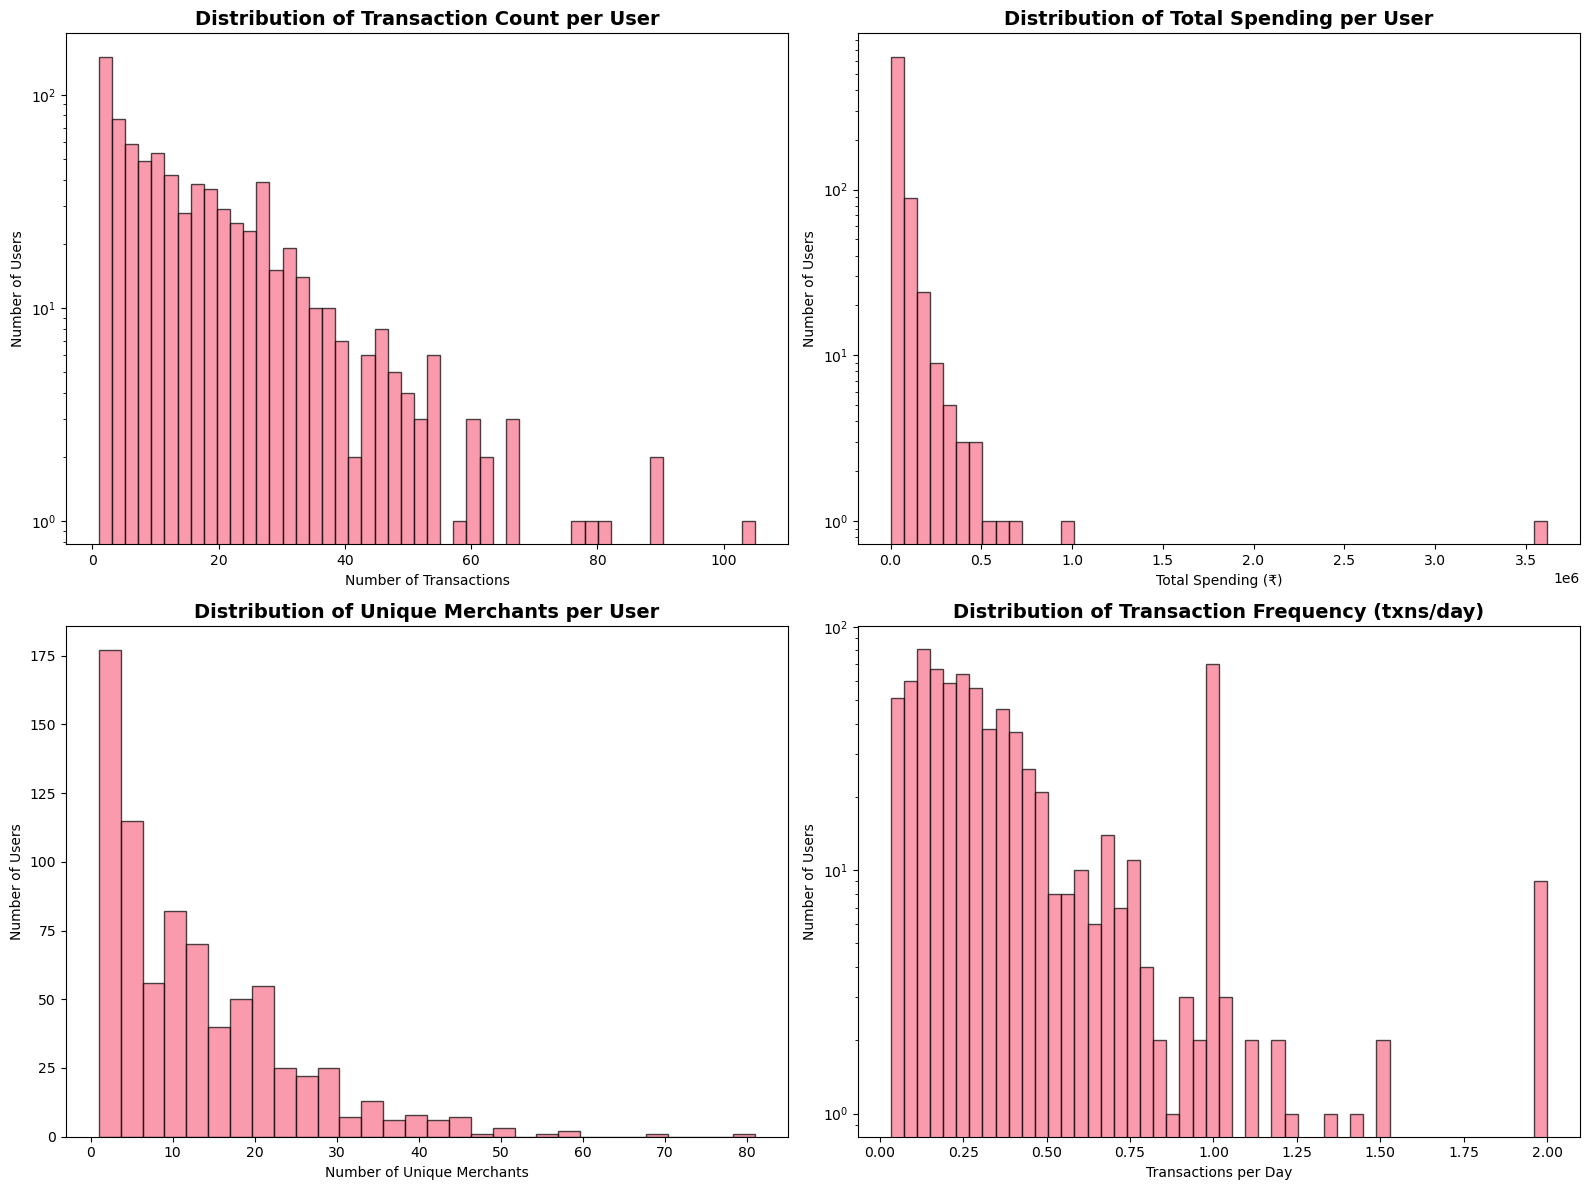


🎯 User Segmentation Analysis:
High-value users (top 10% by spend): 78
  - Average spend: ₹267,190
  - Average transactions: 27.0
  - Average merchants: 21.7

Frequent users (top 10% by txn count): 83
  - Average transactions: 47.5
  - Average spend: ₹81,780
  - Average merchants: 35.9

Loyal users (top 10% by merchant diversity): 81
  - Average merchants: 37.2
  - Average transactions: 46.9
  - Average spend: ₹81,979


In [9]:
# Visualize user behavior patterns
if df is not None and len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Transaction count distribution
    axes[0,0].hist(user_stats['txn_count'], bins=50, edgecolor='black', alpha=0.7)
    axes[0,0].set_title('Distribution of Transaction Count per User', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Number of Transactions')
    axes[0,0].set_ylabel('Number of Users')
    axes[0,0].set_yscale('log')
    
    # Total spending distribution
    axes[0,1].hist(user_stats['total_spent'], bins=50, edgecolor='black', alpha=0.7)
    axes[0,1].set_title('Distribution of Total Spending per User', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Total Spending (₹)')
    axes[0,1].set_ylabel('Number of Users')
    axes[0,1].set_yscale('log')
    
    # Unique merchants per user
    axes[1,0].hist(user_stats['unique_merchants'], bins=30, edgecolor='black', alpha=0.7)
    axes[1,0].set_title('Distribution of Unique Merchants per User', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Number of Unique Merchants')
    axes[1,0].set_ylabel('Number of Users')
    
    # Transaction frequency
    axes[1,1].hist(user_stats['txn_frequency'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1,1].set_title('Distribution of Transaction Frequency (txns/day)', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Transactions per Day')
    axes[1,1].set_ylabel('Number of Users')
    axes[1,1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # User segmentation based on behavior
    print("\n🎯 User Segmentation Analysis:")
    
    # High value users (top 10% by spend)
    high_value_threshold = user_stats['total_spent'].quantile(0.9)
    high_value_users = user_stats[user_stats['total_spent'] >= high_value_threshold]
    print(f"High-value users (top 10% by spend): {len(high_value_users):,}")
    print(f"  - Average spend: ₹{high_value_users['total_spent'].mean():,.0f}")
    print(f"  - Average transactions: {high_value_users['txn_count'].mean():.1f}")
    print(f"  - Average merchants: {high_value_users['unique_merchants'].mean():.1f}")
    
    # Frequent users (top 10% by transaction count)
    frequent_threshold = user_stats['txn_count'].quantile(0.9)
    frequent_users = user_stats[user_stats['txn_count'] >= frequent_threshold]
    print(f"\nFrequent users (top 10% by txn count): {len(frequent_users):,}")
    print(f"  - Average transactions: {frequent_users['txn_count'].mean():.1f}")
    print(f"  - Average spend: ₹{frequent_users['total_spent'].mean():,.0f}")
    print(f"  - Average merchants: {frequent_users['unique_merchants'].mean():.1f}")
    
    # Loyal users (high merchant diversity)
    loyal_threshold = user_stats['unique_merchants'].quantile(0.9)
    loyal_users = user_stats[user_stats['unique_merchants'] >= loyal_threshold]
    print(f"\nLoyal users (top 10% by merchant diversity): {len(loyal_users):,}")
    print(f"  - Average merchants: {loyal_users['unique_merchants'].mean():.1f}")
    print(f"  - Average transactions: {loyal_users['txn_count'].mean():.1f}")
    print(f"  - Average spend: ₹{loyal_users['total_spent'].mean():,.0f}")


## 📅 Temporal Analysis for Contextual Recommendations

### Problem Statement
Understanding when users make transactions is crucial for building contextual reward recommendations. By analyzing temporal patterns, we can:
- Identify peak activity times for different merchant categories
- Optimize reward delivery timing (e.g., send Swiggy offers on Thursday for Friday night orders)
- Understand user behavior cycles (weekday vs weekend patterns)
- Build time-aware recommendation features

### Approach
1. **Feature Engineering**: Extract temporal components from transaction timestamps
2. **Pattern Analysis**: Analyze transaction distribution across different time dimensions
3. **Peak Time Identification**: Find optimal timing for contextual recommendations
4. **Category-Time Mapping**: Link merchant categories to their peak activity periods


In [10]:
# Step 1: Temporal Feature Engineering
print("📅 Temporal Analysis for Contextual Recommendations")
print("=" * 60)

if df is not None and len(df) > 0:
    print("\n🔧 Step 1: Creating Temporal Features")
    print("Extracting time-based components from transaction timestamps...")
    
    # Add temporal features for contextual analysis
    df['hour'] = df['transactiondatetime'].dt.hour
    df['day_of_week'] = df['transactiondatetime'].dt.day_name()
    df['day_of_month'] = df['transactiondatetime'].dt.day
    df['month'] = df['transactiondatetime'].dt.month_name()
    df['is_weekend'] = df['transactiondatetime'].dt.dayofweek >= 5
    
    print(f"✅ Temporal features created successfully!")
    print(f"📊 Data Range: {df['transactiondatetime'].min()} to {df['transactiondatetime'].max()}")
    print(f"⏱️ Analysis Duration: {(df['transactiondatetime'].max() - df['transactiondatetime'].min()).days} days")
    
    print("\n📈 Step 2: Analyzing Transaction Patterns by Time Dimensions")
    
    # Day of week analysis for weekly patterns
    print("\n🗓️ Day-of-Week Pattern Analysis:")
    dow_stats = df.groupby('day_of_week').agg({
        'transactionamount': ['count', 'sum', 'mean']
    }).round(2)
    dow_stats.columns = ['count', 'total_value', 'avg_value']
    
    # Reorder by actual day sequence for better readability
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_stats = dow_stats.reindex(day_order)
    display(dow_stats)
    
    # Hour of day analysis for daily patterns
    print("\n🕐 Hour-of-Day Pattern Analysis:")
    hour_stats = df.groupby('hour').agg({
        'transactionamount': ['count', 'sum', 'mean']
    }).round(2)
    hour_stats.columns = ['count', 'total_value', 'avg_value']
    print("Top 10 peak hours:")
    display(hour_stats.head(10))
    
else:
    print("❌ No data available for temporal analysis")


📅 Temporal Analysis for Contextual Recommendations

🔧 Step 1: Creating Temporal Features
Extracting time-based components from transaction timestamps...
✅ Temporal features created successfully!
📊 Data Range: 2025-01-01 00:00:00+00:00 to 2025-03-21 21:25:01+00:00
⏱️ Analysis Duration: 79 days

📈 Step 2: Analyzing Transaction Patterns by Time Dimensions

🗓️ Day-of-Week Pattern Analysis:


,count,total_value,avg_value
day_of_week,,,
Monday,1674,6590347.33,3936.89
Tuesday,1615,4174491.85,2584.82
Wednesday,1861,5535635.01,2974.55
Thursday,1763,4384019.34,2486.68
Friday,1836,6932821.42,3776.05
Saturday,1704,6132273.07,3598.75
Sunday,1736,3391944.07,1953.88



🕐 Hour-of-Day Pattern Analysis:
Top 10 peak hours:


,count,total_value,avg_value
hour,,,
0,1198,2628009.91,2193.66
1,877,2304625.21,2627.85
2,749,1459628.93,1948.77
3,553,1011920.61,1829.87
4,366,867417.24,2369.99
5,207,579188.60,2798.01
6,116,120983.43,1042.96
7,83,308634.14,3718.48
8,100,180806.03,1808.06


📊 Step 3: Visualizing Temporal Patterns for Recommendation Timing

🎨 Creating comprehensive temporal visualizations...


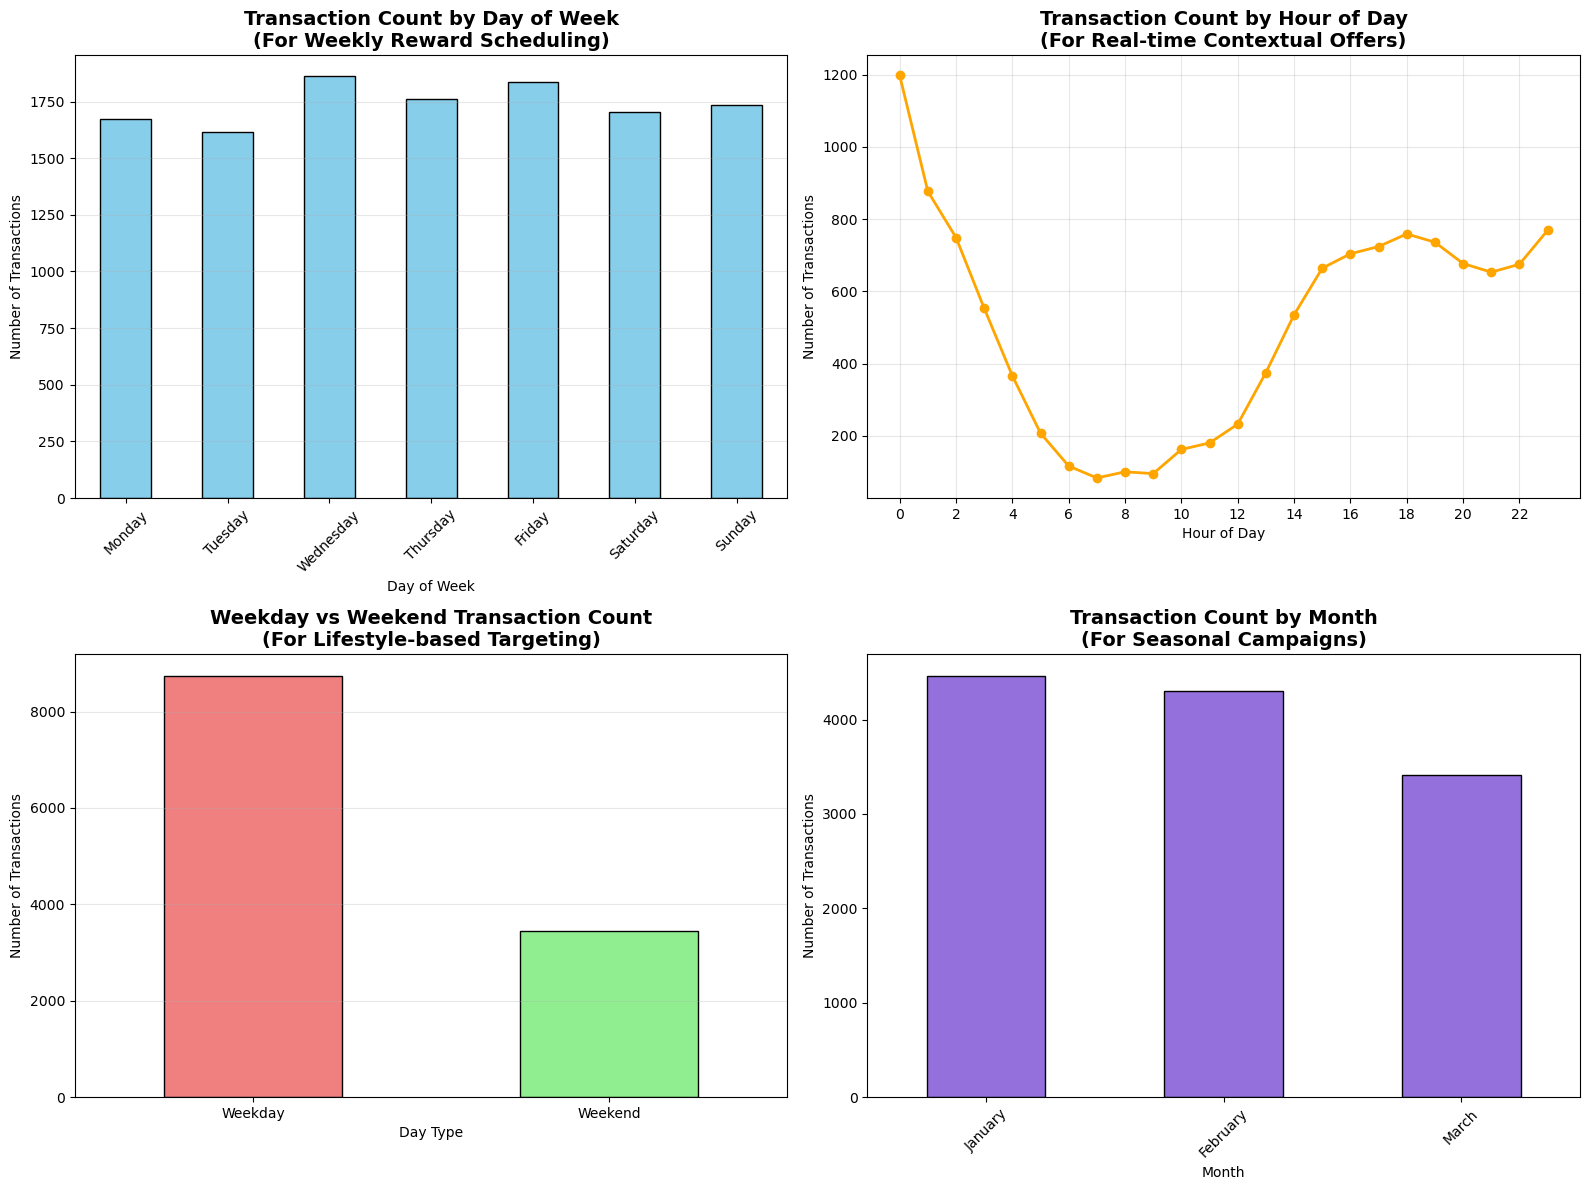


🎯 Key Temporal Insights for Contextual Recommendations:
📈 Peak Activity Day: Wednesday (1,861 transactions)
🕐 Peak Activity Hour: 0:00 (1,198 transactions)
📊 Weekend vs Weekday Ratio: 0.39

💡 Recommendation System Implications:
   • Best day for weekly campaigns: Wednesday
   • Optimal push notification time: 0:00
   • Weekday-focused strategy: Users are 2.5x more active on weekdays

🏷️ Category-Specific Peak Hours (For Targeted Timing):
   1. atm: Peak at 0:00 (53 transactions)
   2. bills & utilities: Peak at 0:00 (41 transactions)
   3. charity: Peak at 0:00 (3 transactions)
   4. commute: Peak at 23:00 (12 transactions)
   5. credit bills: Peak at 0:00 (25 transactions)

✅ Temporal analysis complete - Ready for time-aware recommendation features!


In [11]:
# Step 3: Temporal Pattern Visualization and Insights
print("📊 Step 3: Visualizing Temporal Patterns for Recommendation Timing")
print("=" * 60)

if df is not None and len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    print("\n🎨 Creating comprehensive temporal visualizations...")
    
    # Chart 1: Day of week transaction patterns
    dow_stats['count'].plot(kind='bar', ax=axes[0,0], color='skyblue', edgecolor='black')
    axes[0,0].set_title('Transaction Count by Day of Week\n(For Weekly Reward Scheduling)', 
                       fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Day of Week')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Chart 2: Hour of day patterns
    hour_stats['count'].plot(kind='line', ax=axes[0,1], marker='o', linewidth=2, color='orange')
    axes[0,1].set_title('Transaction Count by Hour of Day\n(For Real-time Contextual Offers)', 
                       fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Number of Transactions')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xticks(range(0, 24, 2))
    
    # Chart 3: Weekend vs weekday comparison
    weekend_comparison = df.groupby('is_weekend').agg({
        'transactionamount': ['count', 'sum', 'mean']
    }).round(2)
    weekend_comparison.columns = ['count', 'total_value', 'avg_value']
    weekend_comparison.index = ['Weekday', 'Weekend']
    
    weekend_comparison['count'].plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightgreen'], 
                                    edgecolor='black')
    axes[1,0].set_title('Weekday vs Weekend Transaction Count\n(For Lifestyle-based Targeting)', 
                       fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Day Type')
    axes[1,0].set_ylabel('Number of Transactions')
    axes[1,0].tick_params(axis='x', rotation=0)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Chart 4: Monthly trends or daily volume
    if df['month'].nunique() > 1:
        month_stats = df.groupby('month')['transactionamount'].count()
        month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
        month_stats = month_stats.reindex([m for m in month_order if m in month_stats.index])
        
        month_stats.plot(kind='bar', ax=axes[1,1], color='mediumpurple', edgecolor='black')
        axes[1,1].set_title('Transaction Count by Month\n(For Seasonal Campaigns)', 
                           fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Month')
        axes[1,1].set_ylabel('Number of Transactions')
        axes[1,1].tick_params(axis='x', rotation=45)
    else:
        # Daily transaction volume over time
        daily_volume = df.set_index('transactiondatetime').resample('D')['transactionamount'].count()
        daily_volume.plot(ax=axes[1,1], color='darkgreen', linewidth=1.5)
        axes[1,1].set_title('Daily Transaction Volume Over Time\n(For Trend Analysis)', 
                           fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Number of Transactions')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Key Temporal Insights for Contextual Recommendations:")
    print("=" * 50)
    
    # Extract key insights for recommendation system
    peak_day = dow_stats['count'].idxmax()
    peak_day_count = dow_stats['count'].max()
    peak_hour = hour_stats['count'].idxmax()
    peak_hour_count = hour_stats['count'].max()
    weekend_ratio = weekend_comparison.loc['Weekend', 'count'] / weekend_comparison.loc['Weekday', 'count']
    
    print(f"📈 Peak Activity Day: {peak_day} ({peak_day_count:,} transactions)")
    print(f"🕐 Peak Activity Hour: {peak_hour}:00 ({peak_hour_count:,} transactions)")
    print(f"📊 Weekend vs Weekday Ratio: {weekend_ratio:.2f}")
    
    # Business recommendations
    print(f"\n💡 Recommendation System Implications:")
    print(f"   • Best day for weekly campaigns: {peak_day}")
    print(f"   • Optimal push notification time: {peak_hour}:00")
    if weekend_ratio > 1:
        print(f"   • Weekend-focused strategy: Users are {weekend_ratio:.1f}x more active on weekends")
    else:
        print(f"   • Weekday-focused strategy: Users are {1/weekend_ratio:.1f}x more active on weekdays")
    
    # Category-specific peak time analysis
    if 'jupiter_coarsegrain_category' in df.columns:
        print(f"\n🏷️ Category-Specific Peak Hours (For Targeted Timing):")
        print("=" * 50)
        category_hour = df.groupby(['jupiter_coarsegrain_category', 'hour'])['transactionamount'].count().unstack(fill_value=0)
        
        for i, category in enumerate(category_hour.index[:5]):  # Top 5 categories
            peak_hour = category_hour.loc[category].idxmax()
            peak_count = category_hour.loc[category].max()
            print(f"   {i+1}. {category}: Peak at {peak_hour}:00 ({peak_count:,} transactions)")
            
    print(f"\n✅ Temporal analysis complete - Ready for time-aware recommendation features!")

else:
    print("❌ No data available for temporal visualization")


## 🏦 Bank Analysis for Partnership & Distribution Strategy

### Problem Statement
Understanding bank-wise transaction patterns is crucial for Jupiter's business strategy and recommendation system optimization. This analysis helps:
- **Partnership Strategy**: Identify high-volume banks for potential collaboration and co-branded rewards
- **User Segmentation**: Understand user banking preferences and financial behavior patterns  
- **Distribution Planning**: Focus marketing efforts on banks with highest user concentration
- **Risk Assessment**: Analyze transaction distribution across different banking partners

### Key Questions to Answer
1. **Which banks generate the highest transaction volumes?**
2. **How do transaction patterns vary across different banks over time?**
3. **What are the user penetration rates for different banking partners?**
4. **Which banks show growth potential for future partnerships?**

### Approach
1. **Bank Transaction Analysis**: Analyze volume, value, and frequency patterns by bank
2. **Temporal Bank Trends**: Study how different banks perform over time periods
3. **User-Bank Affinity**: Understand user loyalty and switching patterns
4. **Partnership Opportunity Identification**: Rank banks for potential reward partnerships


In [12]:
# Step 1: Comprehensive Bank Analysis
print("🏦 Bank Analysis for Partnership & Distribution Strategy")
print("=" * 65)

if df is not None and len(df) > 0:
    print("\n📊 Step 1: Bank Transaction Volume & Value Analysis")
    print("=" * 50)
    
    # Comprehensive bank statistics
    bank_stats = df.groupby('bankname').agg({
        'transactionamount': ['count', 'sum', 'mean', 'median', 'std'],
        'user_id': 'nunique',
        'transactiondatetime': ['min', 'max'],
        'merchant_clean': 'nunique'
    }).round(2)
    
    bank_stats.columns = ['txn_count', 'total_value', 'avg_amount', 'median_amount', 
                         'amount_std', 'unique_users', 'first_txn', 'last_txn', 'unique_merchants']
    
    # Calculate additional metrics for partnership evaluation
    bank_stats['days_active'] = (bank_stats['last_txn'] - bank_stats['first_txn']).dt.days + 1
    bank_stats['txn_per_day'] = bank_stats['txn_count'] / bank_stats['days_active']
    bank_stats['avg_users_per_day'] = bank_stats['unique_users'] / bank_stats['days_active']
    bank_stats['user_penetration'] = (bank_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    bank_stats['avg_txn_per_user'] = (bank_stats['txn_count'] / bank_stats['unique_users']).round(2)
    bank_stats['value_per_user'] = (bank_stats['total_value'] / bank_stats['unique_users']).round(2)
    
    print(f"📈 Total Banks Analyzed: {len(bank_stats):,}")
    print(f"💰 Total Transaction Value: ₹{df['transactionamount'].sum():,.0f}")
    print(f"📊 Average transactions per bank: {bank_stats['txn_count'].mean():.1f}")
    print(f"👥 Average users per bank: {bank_stats['unique_users'].mean():.1f}")
    
    print("\n🏆 TOP 20 BANKS BY TRANSACTION COUNT:")
    top_banks_count = bank_stats.sort_values('txn_count', ascending=False).head(20)
    display(top_banks_count[['txn_count', 'total_value', 'unique_users', 'user_penetration', 
                            'avg_amount', 'unique_merchants']])
    
    print("\n💎 TOP 20 BANKS BY TOTAL TRANSACTION VALUE:")
    top_banks_value = bank_stats.sort_values('total_value', ascending=False).head(20)
    display(top_banks_value[['total_value', 'txn_count', 'unique_users', 'user_penetration', 
                            'avg_amount', 'value_per_user']])
    
    print("\n👥 TOP 20 BANKS BY USER PENETRATION:")
    top_banks_users = bank_stats.sort_values('user_penetration', ascending=False).head(20)
    display(top_banks_users[['user_penetration', 'unique_users', 'txn_count', 'avg_txn_per_user', 
                            'total_value', 'value_per_user']])
    
else:
    print("❌ No data available for bank analysis")


🏦 Bank Analysis for Partnership & Distribution Strategy

📊 Step 1: Bank Transaction Volume & Value Analysis
📈 Total Banks Analyzed: 18
💰 Total Transaction Value: ₹37,141,532
📊 Average transactions per bank: 677.2
👥 Average users per bank: 53.6

🏆 TOP 20 BANKS BY TRANSACTION COUNT:


,txn_count,total_value,unique_users,user_penetration,avg_amount,unique_merchants
bankname,,,,,,
Canara Bank,2391,6096518.57,173,22.38,2549.78,1594
HDFC Bank,2016,8494217.33,153,19.79,4213.40,1468
STATE BANK OF INDIA,1624,2702884.94,132,17.08,1664.34,1191
Kotak Mahindra Bank,1108,2284063.96,104,13.45,2061.43,876
Union Bank Of India,877,1422811.22,61,7.89,1622.36,683
Axis Bank,805,2732523.89,67,8.67,3394.44,605
ICICI Bank,801,7297162.03,60,7.76,9110.06,578
BANK OF BARODA,727,2080682.21,56,7.24,2862.01,599
FEDERAL BANK,539,941591.35,43,5.56,1746.92,428



💎 TOP 20 BANKS BY TOTAL TRANSACTION VALUE:


,total_value,txn_count,unique_users,user_penetration,avg_amount,value_per_user
bankname,,,,,,
HDFC Bank,8494217.33,2016,153,19.79,4213.40,55517.76
ICICI Bank,7297162.03,801,60,7.76,9110.06,121619.37
Canara Bank,6096518.57,2391,173,22.38,2549.78,35239.99
Axis Bank,2732523.89,805,67,8.67,3394.44,40783.94
STATE BANK OF INDIA,2702884.94,1624,132,17.08,1664.34,20476.40
Kotak Mahindra Bank,2284063.96,1108,104,13.45,2061.43,21962.15
BANK OF BARODA,2080682.21,727,56,7.24,2862.01,37155.04
Union Bank Of India,1422811.22,877,61,7.89,1622.36,23324.77
IDFC FIRST BANK,1036767.00,208,22,2.85,4984.46,47125.77



👥 TOP 20 BANKS BY USER PENETRATION:


,user_penetration,unique_users,txn_count,avg_txn_per_user,total_value,value_per_user
bankname,,,,,,
Canara Bank,22.38,173,2391,13.82,6096518.57,35239.99
HDFC Bank,19.79,153,2016,13.18,8494217.33,55517.76
STATE BANK OF INDIA,17.08,132,1624,12.30,2702884.94,20476.40
Kotak Mahindra Bank,13.45,104,1108,10.65,2284063.96,21962.15
Axis Bank,8.67,67,805,12.01,2732523.89,40783.94
Union Bank Of India,7.89,61,877,14.38,1422811.22,23324.77
ICICI Bank,7.76,60,801,13.35,7297162.03,121619.37
BANK OF BARODA,7.24,56,727,12.98,2080682.21,37155.04
FEDERAL BANK,5.56,43,539,12.53,941591.35,21897.47


📊 Step 2: Bank Distribution Patterns & Temporal Trends

🎨 Creating bank distribution and trend visualizations...
\n📈 Analyzing temporal trends for top banks...


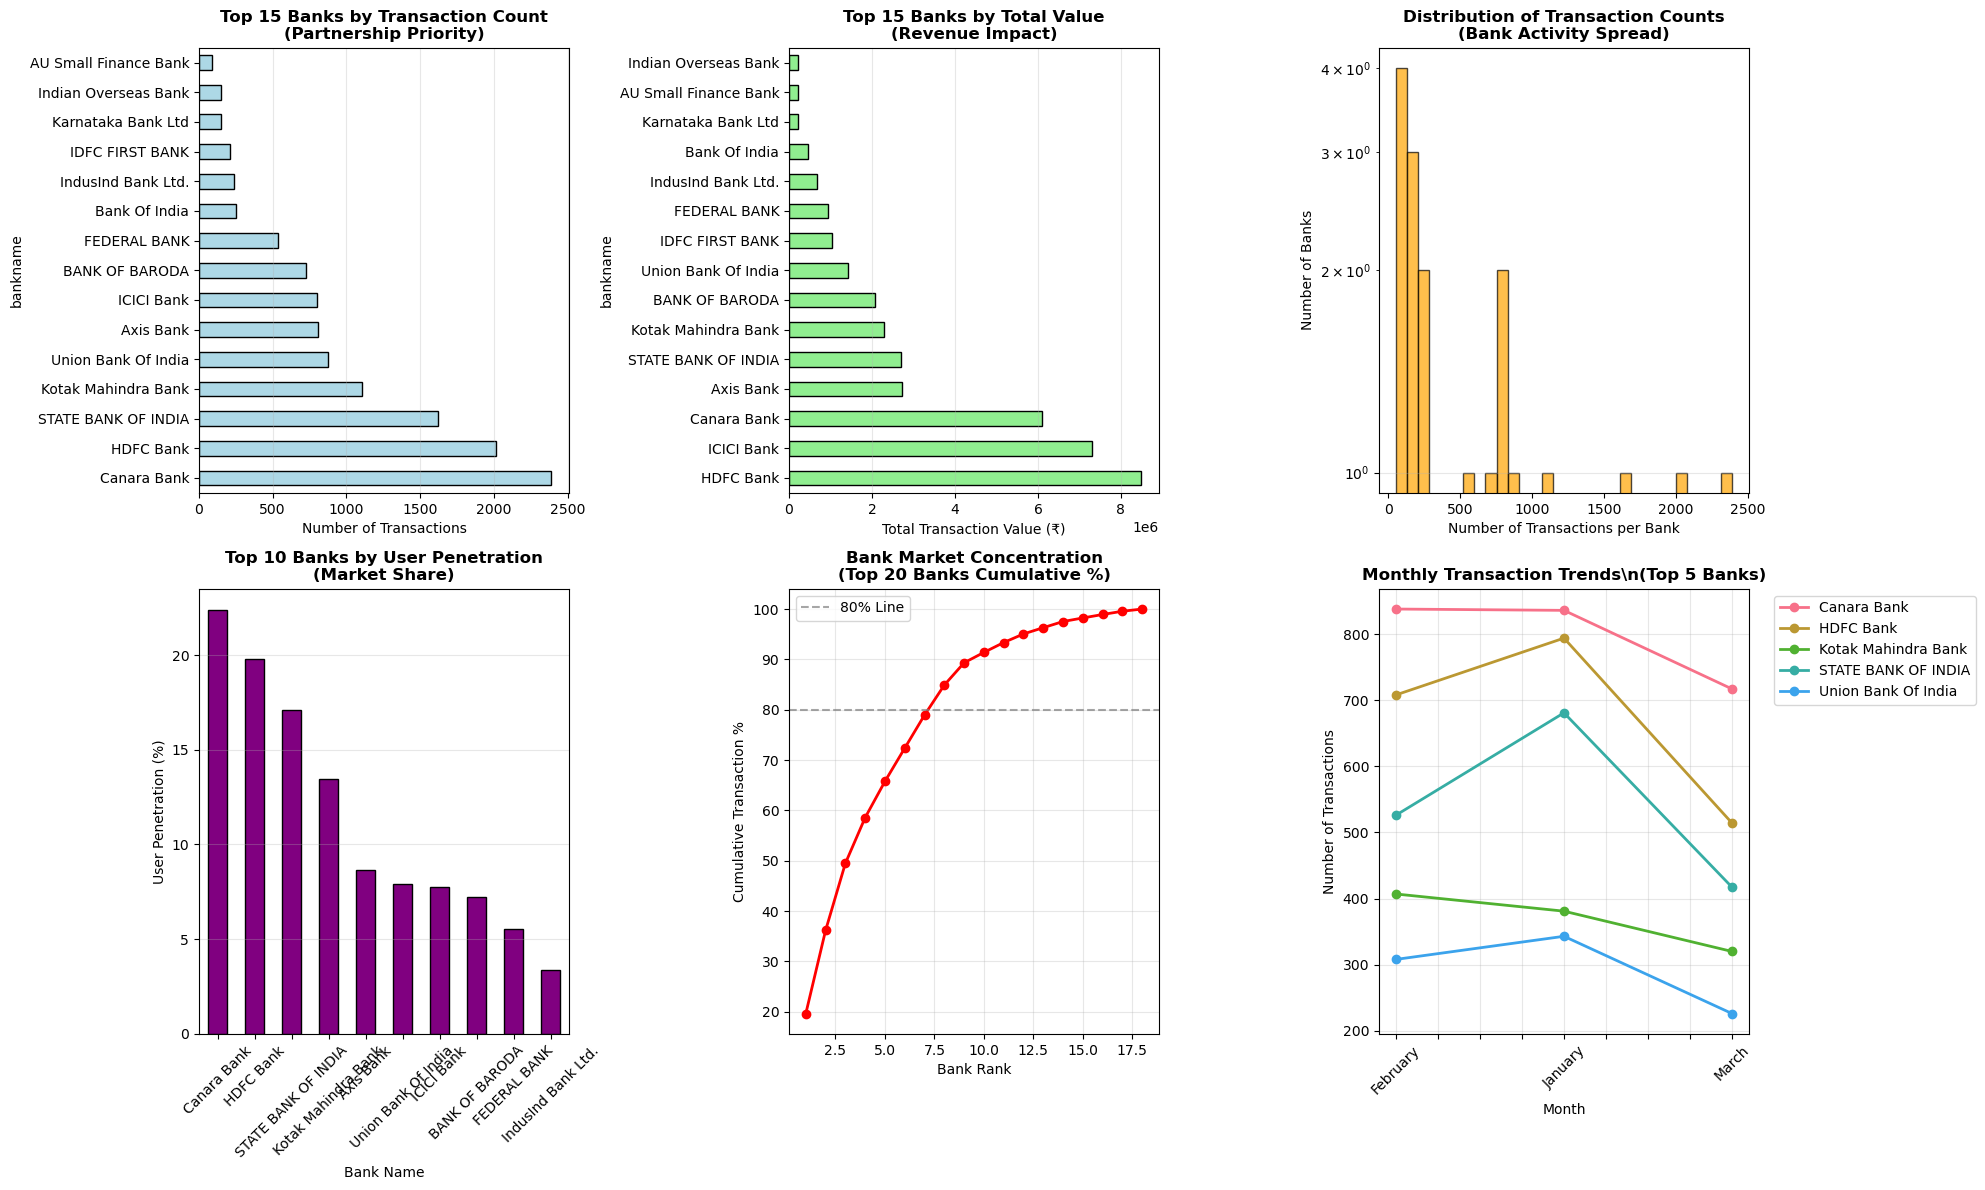

\n🎯 Key Bank Analysis Insights:
🏆 Top Bank: Canara Bank (2,391 transactions)
📊 Top 5 Banks Control: 65.8% of total transactions
📈 Top 10 Banks Control: 91.4% of total transactions
\n💼 Partnership Opportunity Analysis:
🎯 High-Priority Partnership Candidates (6 banks):
   1. HDFC Bank: 19.8% users, ₹8,494,217 value
   2. ICICI Bank: 7.8% users, ₹7,297,162 value
   3. Canara Bank: 22.4% users, ₹6,096,519 value
   4. Axis Bank: 8.7% users, ₹2,732,524 value
   5. STATE BANK OF INDIA: 17.1% users, ₹2,702,885 value
\n⚡ Market Fragmentation: High variation in bank usage (std: 6.9%)
   • Opportunity for targeted bank-specific campaigns


In [13]:
# Step 2: Bank Distribution Visualizations and Temporal Analysis
print("📊 Step 2: Bank Distribution Patterns & Temporal Trends")
print("=" * 55)

if df is not None and len(df) > 0:
    
    # Create comprehensive bank visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    print("\n🎨 Creating bank distribution and trend visualizations...")
    
    # Chart 1: Top banks by transaction count
    top_15_banks_count = bank_stats.sort_values('txn_count', ascending=False).head(15)
    top_15_banks_count['txn_count'].plot(kind='barh', ax=axes[0,0], color='lightblue', edgecolor='black')
    axes[0,0].set_title('Top 15 Banks by Transaction Count\n(Partnership Priority)', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Number of Transactions')
    axes[0,0].grid(axis='x', alpha=0.3)
    
    # Chart 2: Top banks by transaction value
    top_15_banks_value = bank_stats.sort_values('total_value', ascending=False).head(15)
    top_15_banks_value['total_value'].plot(kind='barh', ax=axes[0,1], color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Top 15 Banks by Total Value\n(Revenue Impact)', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Total Transaction Value (₹)')
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # Chart 3: Bank transaction frequency distribution
    axes[0,2].hist(bank_stats['txn_count'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0,2].set_title('Distribution of Transaction Counts\n(Bank Activity Spread)', fontsize=12, fontweight='bold')
    axes[0,2].set_xlabel('Number of Transactions per Bank')
    axes[0,2].set_ylabel('Number of Banks')
    axes[0,2].set_yscale('log')
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # Chart 4: User penetration by top banks
    top_10_penetration = bank_stats.sort_values('user_penetration', ascending=False).head(10)
    top_10_penetration['user_penetration'].plot(kind='bar', ax=axes[1,0], color='purple', edgecolor='black')
    axes[1,0].set_title('Top 10 Banks by User Penetration\n(Market Share)', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Bank Name')
    axes[1,0].set_ylabel('User Penetration (%)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Chart 5: Bank concentration analysis
    bank_concentration = df['bankname'].value_counts()
    total_transactions = len(df)
    
    # Calculate cumulative percentage
    cumulative_pct = (bank_concentration.cumsum() / total_transactions * 100)
    bank_rank = range(1, len(cumulative_pct) + 1)
    
    axes[1,1].plot(bank_rank[:20], cumulative_pct.iloc[:20], marker='o', linewidth=2, color='red')
    axes[1,1].set_title('Bank Market Concentration\n(Top 20 Banks Cumulative %)', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Bank Rank')
    axes[1,1].set_ylabel('Cumulative Transaction %')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=80, color='gray', linestyle='--', alpha=0.7, label='80% Line')
    axes[1,1].legend()
    
    # Chart 6: Temporal bank analysis - Monthly trends for top banks
    if 'month' in df.columns:
        print("\\n📈 Analyzing temporal trends for top banks...")
        top_5_banks = bank_stats.sort_values('txn_count', ascending=False).head(5).index
        
        monthly_bank_trends = df[df['bankname'].isin(top_5_banks)].groupby(['month', 'bankname']).size().unstack(fill_value=0)
        
        if len(monthly_bank_trends) > 1:
            monthly_bank_trends.plot(kind='line', ax=axes[1,2], marker='o', linewidth=2)
            axes[1,2].set_title('Monthly Transaction Trends\\n(Top 5 Banks)', fontsize=12, fontweight='bold')
            axes[1,2].set_xlabel('Month')
            axes[1,2].set_ylabel('Number of Transactions')
            axes[1,2].tick_params(axis='x', rotation=45)
            axes[1,2].grid(True, alpha=0.3)
            axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            # If only one month, show daily trends
            daily_bank_trends = df[df['bankname'].isin(top_5_banks)].groupby([df['transactiondatetime'].dt.date, 'bankname']).size().unstack(fill_value=0)
            daily_bank_trends.plot(ax=axes[1,2], linewidth=1.5)
            axes[1,2].set_title('Daily Transaction Trends\\n(Top 5 Banks)', fontsize=12, fontweight='bold')
            axes[1,2].set_xlabel('Date')
            axes[1,2].set_ylabel('Number of Transactions')
            axes[1,2].tick_params(axis='x', rotation=45)
            axes[1,2].grid(True, alpha=0.3)
            axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print("\\n🎯 Key Bank Analysis Insights:")
    print("=" * 40)
    
    # Market concentration insights
    top_5_bank_share = (bank_concentration.head(5).sum() / total_transactions * 100)
    top_10_bank_share = (bank_concentration.head(10).sum() / total_transactions * 100)
    
    print(f"🏆 Top Bank: {bank_concentration.index[0]} ({bank_concentration.iloc[0]:,} transactions)")
    print(f"📊 Top 5 Banks Control: {top_5_bank_share:.1f}% of total transactions")
    print(f"📈 Top 10 Banks Control: {top_10_bank_share:.1f}% of total transactions")
    
    # Partnership opportunities
    print(f"\\n💼 Partnership Opportunity Analysis:")
    high_value_banks = bank_stats[
        (bank_stats['user_penetration'] >= 5) & 
        (bank_stats['total_value'] >= bank_stats['total_value'].quantile(0.7))
    ].sort_values('total_value', ascending=False)
    
    if len(high_value_banks) > 0:
        print(f"🎯 High-Priority Partnership Candidates ({len(high_value_banks)} banks):")
        for i, (bank, stats) in enumerate(high_value_banks.head(5).iterrows(), 1):
            print(f"   {i}. {bank}: {stats['user_penetration']:.1f}% users, ₹{stats['total_value']:,.0f} value")
    
    # Market distribution insights
    if bank_stats['user_penetration'].std() > 5:
        print(f"\\n⚡ Market Fragmentation: High variation in bank usage (std: {bank_stats['user_penetration'].std():.1f}%)")
        print(f"   • Opportunity for targeted bank-specific campaigns")
    else:
        print(f"\\n📊 Market Distribution: Relatively balanced bank usage")
        print(f"   • Focus on broad-based partnership strategies")

else:
    print("❌ No data available for bank visualization")


## 🏷️ Category Analysis for Recommendation Targeting


In [14]:
# Category analysis for targeted recommendations
print("🏷️ Category Analysis")
print("=" * 50)

if df is not None and len(df) > 0:
    # Analyze different category fields
    category_fields = ['jupiter_coarsegrain_category', 'jupiterfinegraincategory', 'usercategory', 'appcategory']
    
    for field in category_fields:
        if field in df.columns:
            print(f"\n📊 {field.replace('_', ' ').title()} Distribution:")
            cat_stats = df.groupby(field).agg({
                'transactionamount': ['count', 'sum', 'mean'],
                'user_id': 'nunique'
            }).round(2)
            cat_stats.columns = ['txn_count', 'total_value', 'avg_txn_value', 'unique_users']
            cat_stats = cat_stats.sort_values('txn_count', ascending=False)
            
            print(f"Top 10 categories by transaction count:")
            print(cat_stats.head(10))
            
            # Category penetration (% of users who transact in each category)
            total_users = df['user_id'].nunique()
            cat_stats['user_penetration'] = (cat_stats['unique_users'] / total_users * 100).round(1)
            
            print(f"\nTop categories by user penetration:")
            top_penetration = cat_stats.sort_values('user_penetration', ascending=False).head(10)
            for idx, row in top_penetration.iterrows():
                print(f"  {idx}: {row['user_penetration']:.1f}% of users ({row['unique_users']:,} users)")
            
            break  # Focus on the first available category field


🏷️ Category Analysis

📊 Jupiter Coarsegrain Category Distribution:
Top 10 categories by transaction count:
                              txn_count  total_value  avg_txn_value  \
jupiter_coarsegrain_category                                          
uncategorised                      8196  24795442.07        3025.31   
food & drinks                       845    239941.98         283.96   
groceries                           534    173046.97         324.06   
bills & utilities                   530   1641594.45        3097.35   
loans                               381   2554332.77        6704.29   
credit bills                        242   3724781.79       15391.66   
entertainment                       209    696510.67        3332.59   
shopping                            199    231143.30        1161.52   
atm                                 167    725908.43        4346.76   
investments                         152    846118.36        5566.57   

                              unique_use

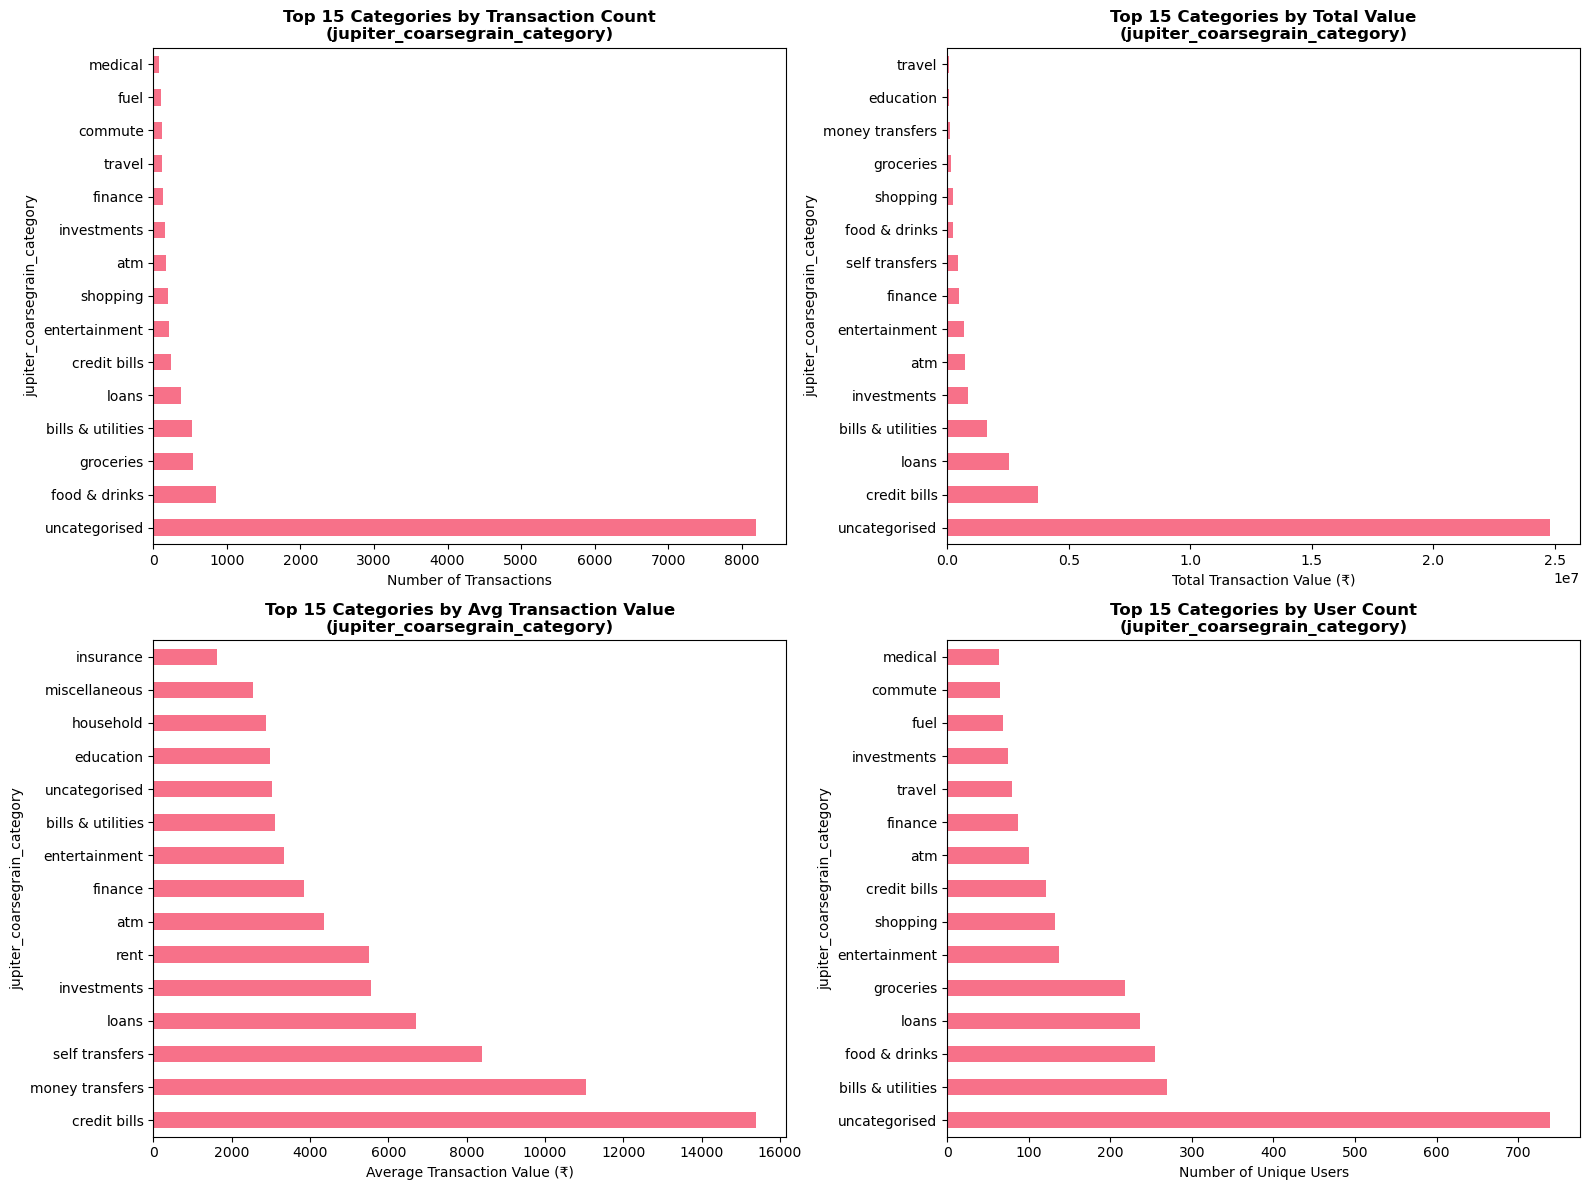


🔄 Cross-Category Behavior Analysis:
Users with single category: 165 (21.3%)
Users with multiple categories: 608 (78.7%)
Average categories per user: 3.6
Max categories per user: 13

🔗 Most Common Category Combinations (for users with 2+ categories):
  Multiple: 327 users
  loans + uncategorised: 36 users
  bills & utilities + uncategorised: 22 users
  finance + uncategorised: 16 users
  food & drinks + uncategorised: 16 users
  atm + uncategorised: 14 users
  groceries + uncategorised: 9 users
  food & drinks + groceries + uncategorised: 9 users
  entertainment + uncategorised: 9 users
  credit bills + loans + uncategorised: 8 users


In [15]:
# Category visualization and cross-category analysis
if df is not None and len(df) > 0:
    # Use the first available category field
    main_category_field = None
    for field in ['jupiter_coarsegrain_category', 'jupiterfinegraincategory', 'usercategory', 'appcategory']:
        if field in df.columns and df[field].notna().sum() > 0:
            main_category_field = field
            break
    
    if main_category_field:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Category distribution by transaction count
        cat_counts = df[main_category_field].value_counts().head(15)
        cat_counts.plot(kind='barh', ax=axes[0,0])
        axes[0,0].set_title(f'Top 15 Categories by Transaction Count\n({main_category_field})', fontsize=12, fontweight='bold')
        axes[0,0].set_xlabel('Number of Transactions')
        
        # Category distribution by value
        cat_values = df.groupby(main_category_field)['transactionamount'].sum().sort_values(ascending=False).head(15)
        cat_values.plot(kind='barh', ax=axes[0,1])
        axes[0,1].set_title(f'Top 15 Categories by Total Value\n({main_category_field})', fontsize=12, fontweight='bold')
        axes[0,1].set_xlabel('Total Transaction Value (₹)')
        
        # Average transaction value by category
        cat_avg = df.groupby(main_category_field)['transactionamount'].mean().sort_values(ascending=False).head(15)
        cat_avg.plot(kind='barh', ax=axes[1,0])
        axes[1,0].set_title(f'Top 15 Categories by Avg Transaction Value\n({main_category_field})', fontsize=12, fontweight='bold')
        axes[1,0].set_xlabel('Average Transaction Value (₹)')
        
        # User penetration by category
        cat_users = df.groupby(main_category_field)['user_id'].nunique().sort_values(ascending=False).head(15)
        cat_users.plot(kind='barh', ax=axes[1,1])
        axes[1,1].set_title(f'Top 15 Categories by User Count\n({main_category_field})', fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Number of Unique Users')
        
        plt.tight_layout()
        plt.show()
        
        # Cross-category behavior analysis
        print(f"\n🔄 Cross-Category Behavior Analysis:")
        user_categories = df.groupby('user_id')[main_category_field].apply(lambda x: set(x.dropna())).reset_index()
        user_categories['category_count'] = user_categories[main_category_field].apply(len)
        
        print(f"Users with single category: {(user_categories['category_count'] == 1).sum():,} ({(user_categories['category_count'] == 1).mean()*100:.1f}%)")
        print(f"Users with multiple categories: {(user_categories['category_count'] > 1).sum():,} ({(user_categories['category_count'] > 1).mean()*100:.1f}%)")
        print(f"Average categories per user: {user_categories['category_count'].mean():.1f}")
        print(f"Max categories per user: {user_categories['category_count'].max()}")
        
        # Most common category combinations
        multi_cat_users = user_categories[user_categories['category_count'] > 1]
        if len(multi_cat_users) > 0:
            print(f"\n🔗 Most Common Category Combinations (for users with 2+ categories):")
            category_combinations = multi_cat_users[main_category_field].apply(lambda x: tuple(sorted(x)) if len(x) <= 3 else 'Multiple')
            combo_counts = category_combinations.value_counts().head(10)
            for combo, count in combo_counts.items():
                if combo != 'Multiple':
                    print(f"  {' + '.join(combo)}: {count:,} users")
                else:
                    print(f"  {combo}: {count:,} users")
    
    else:
        print("❌ No valid category field found for analysis")


In [16]:
# User-Merchant interaction analysis for recommendation systems
print("🎯 User-Merchant Interaction Analysis")
print("=" * 50)

if df is not None and len(df) > 0:
    # Create user-merchant interaction matrix
    print("\n📊 Creating User-Merchant Interaction Matrix...")
    
    # Focus on users and merchants with sufficient activity
    min_user_transactions = 3
    min_merchant_transactions = 10
    
    # Filter active users and merchants
    active_users = df.groupby('user_id').size()
    active_users = active_users[active_users >= min_user_transactions].index
    
    active_merchants = df.groupby('merchant_clean').size()
    active_merchants = active_merchants[active_merchants >= min_merchant_transactions].index
    
    df_filtered = df[
        (df['user_id'].isin(active_users)) & 
        (df['merchant_clean'].isin(active_merchants))
    ].copy()
    
    print(f"Active users (≥{min_user_transactions} transactions): {len(active_users):,}")
    print(f"Active merchants (≥{min_merchant_transactions} transactions): {len(active_merchants):,}")
    print(f"Filtered dataset size: {len(df_filtered):,} transactions")
    
    if len(df_filtered) > 0:
        # Create interaction matrix (user-merchant transaction counts)
        interaction_matrix = df_filtered.groupby(['user_id', 'merchant_clean']).size().unstack(fill_value=0)
        
        print(f"\n📈 Interaction Matrix Shape: {interaction_matrix.shape}")
        
        # Calculate sparsity
        total_cells = interaction_matrix.shape[0] * interaction_matrix.shape[1]
        non_zero_cells = (interaction_matrix > 0).sum().sum()
        sparsity = 1 - (non_zero_cells / total_cells)
        
        print(f"Matrix sparsity: {sparsity:.4f} ({sparsity*100:.2f}% empty)")
        print(f"Non-zero interactions: {non_zero_cells:,} out of {total_cells:,} possible")
        
        # Analyze interaction patterns
        user_merchant_counts = (interaction_matrix > 0).sum(axis=1)
        merchant_user_counts = (interaction_matrix > 0).sum(axis=0)
        
        print(f"\n👥 User Interaction Patterns:")
        print(f"Average merchants per user: {user_merchant_counts.mean():.1f}")
        print(f"Median merchants per user: {user_merchant_counts.median():.1f}")
        print(f"Max merchants per user: {user_merchant_counts.max()}")
        
        print(f"\n🏪 Merchant Interaction Patterns:")
        print(f"Average users per merchant: {merchant_user_counts.mean():.1f}")
        print(f"Median users per merchant: {merchant_user_counts.median():.1f}")
        print(f"Max users per merchant: {merchant_user_counts.max()}")
        
    else:
        print("❌ Insufficient data for interaction matrix analysis")


🎯 User-Merchant Interaction Analysis

📊 Creating User-Merchant Interaction Matrix...
Active users (≥3 transactions): 663
Active merchants (≥10 transactions): 52
Filtered dataset size: 1,081 transactions

📈 Interaction Matrix Shape: (344, 52)
Matrix sparsity: 0.9687 (96.87% empty)
Non-zero interactions: 560 out of 17,888 possible

👥 User Interaction Patterns:
Average merchants per user: 1.6
Median merchants per user: 1.0
Max merchants per user: 6

🏪 Merchant Interaction Patterns:
Average users per merchant: 10.8
Median users per merchant: 8.5
Max users per merchant: 65



🔍 Collaborative Filtering Feasibility Analysis:


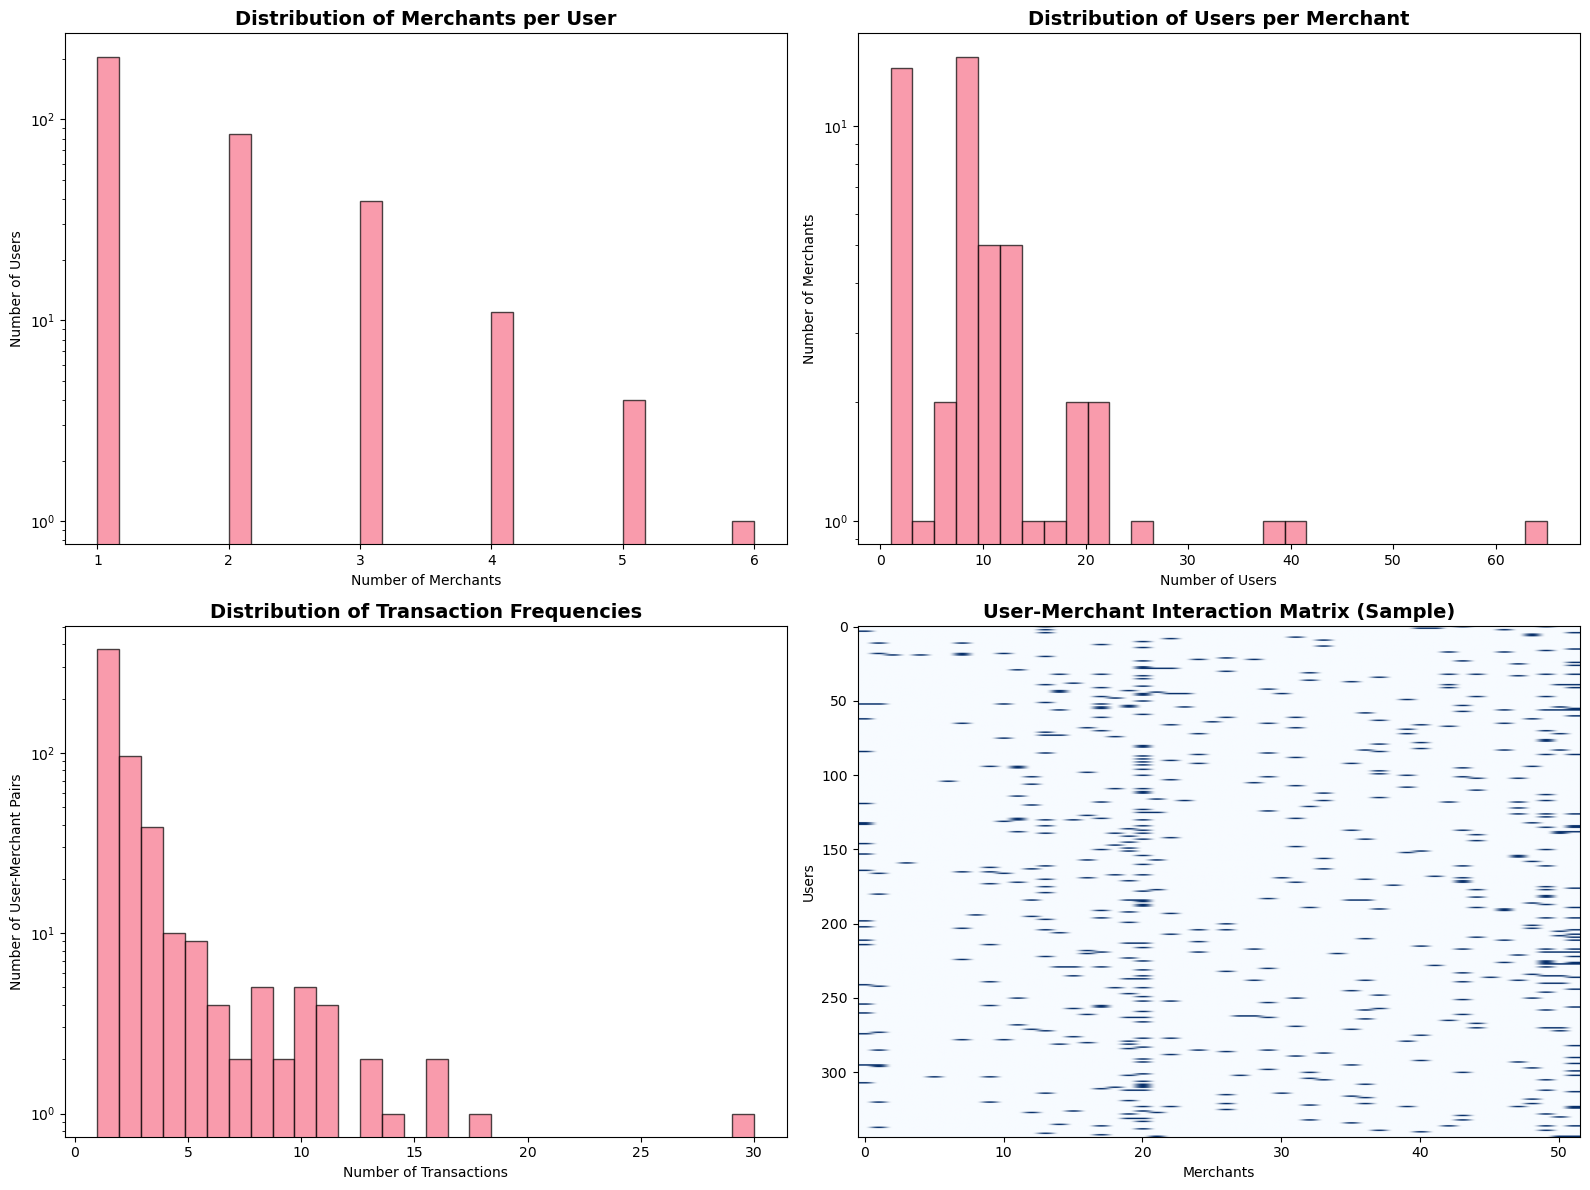


🎯 Recommendation System Design Insights:
Cold start challenges:
  - Users with only 1 merchant: 205 (59.6%)
  - Merchants with only 1 user: 10 (19.2%)

Collaborative filtering potential:
  - Users with 2+ merchants: 139 (40.4%)
  - Merchants with 2+ users: 42 (80.8%)

✅ Moderate sparsity (0.9687) suggests:
  - Collaborative filtering is feasible with proper techniques
  - Matrix factorization methods recommended
  - Consider ensemble approaches


In [17]:
# Collaborative filtering feasibility analysis
if df is not None and len(df) > 0 and 'interaction_matrix' in locals():
    print("\n🔍 Collaborative Filtering Feasibility Analysis:")
    
    # Visualize sparsity and interaction patterns
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # User interaction distribution
    axes[0,0].hist(user_merchant_counts, bins=30, edgecolor='black', alpha=0.7)
    axes[0,0].set_title('Distribution of Merchants per User', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Number of Merchants')
    axes[0,0].set_ylabel('Number of Users')
    axes[0,0].set_yscale('log')
    
    # Merchant interaction distribution
    axes[0,1].hist(merchant_user_counts, bins=30, edgecolor='black', alpha=0.7)
    axes[0,1].set_title('Distribution of Users per Merchant', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Number of Users')
    axes[0,1].set_ylabel('Number of Merchants')
    axes[0,1].set_yscale('log')
    
    # Transaction frequency distribution
    transaction_frequencies = interaction_matrix.values[interaction_matrix.values > 0]
    axes[1,0].hist(transaction_frequencies, bins=30, edgecolor='black', alpha=0.7)
    axes[1,0].set_title('Distribution of Transaction Frequencies', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Number of Transactions')
    axes[1,0].set_ylabel('Number of User-Merchant Pairs')
    axes[1,0].set_yscale('log')
    
    # Sparsity visualization (sample of matrix)
    if interaction_matrix.shape[0] > 100 and interaction_matrix.shape[1] > 100:
        sample_matrix = interaction_matrix.iloc[:100, :100]
    else:
        sample_matrix = interaction_matrix
    
    im = axes[1,1].imshow(sample_matrix.values > 0, cmap='Blues', aspect='auto')
    axes[1,1].set_title('User-Merchant Interaction Matrix (Sample)', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Merchants')
    axes[1,1].set_ylabel('Users')
    
    plt.tight_layout()
    plt.show()
    
    # Recommendation system insights
    print(f"\n🎯 Recommendation System Design Insights:")
    
    # Cold start problem analysis
    single_merchant_users = (user_merchant_counts == 1).sum()
    single_user_merchants = (merchant_user_counts == 1).sum()
    
    print(f"Cold start challenges:")
    print(f"  - Users with only 1 merchant: {single_merchant_users:,} ({single_merchant_users/len(user_merchant_counts)*100:.1f}%)")
    print(f"  - Merchants with only 1 user: {single_user_merchants:,} ({single_user_merchants/len(merchant_user_counts)*100:.1f}%)")
    
    # Data sufficiency for collaborative filtering
    users_with_multiple_merchants = (user_merchant_counts >= 2).sum()
    merchants_with_multiple_users = (merchant_user_counts >= 2).sum()
    
    print(f"\nCollaborative filtering potential:")
    print(f"  - Users with 2+ merchants: {users_with_multiple_merchants:,} ({users_with_multiple_merchants/len(user_merchant_counts)*100:.1f}%)")
    print(f"  - Merchants with 2+ users: {merchants_with_multiple_users:,} ({merchants_with_multiple_users/len(merchant_user_counts)*100:.1f}%)")
    
    # Recommendation approaches
    if sparsity > 0.99:
        print(f"\n⚠️ High sparsity ({sparsity:.4f}) suggests:")
        print("  - Content-based filtering may be more effective initially")
        print("  - Hybrid approaches combining content and collaborative filtering")
        print("  - Consider implicit feedback and contextual features")
    elif sparsity > 0.95:
        print(f"\n✅ Moderate sparsity ({sparsity:.4f}) suggests:")
        print("  - Collaborative filtering is feasible with proper techniques")
        print("  - Matrix factorization methods recommended")
        print("  - Consider ensemble approaches")
    else:
        print(f"\n🎯 Low sparsity ({sparsity:.4f}) is ideal for:")
        print("  - Traditional collaborative filtering")
        print("  - Neighborhood-based methods")
        print("  - Deep learning approaches")


In [18]:
# User persona identification for targeted recommendations
print("🎭 User Persona Identification")
print("=" * 50)

if df is not None and len(df) > 0:
    # Create user features for clustering
    print("\n📊 Creating User Feature Profiles...")
    
    # Aggregate user behavior features
    user_features = df.groupby('user_id').agg({
        'transactionamount': ['count', 'sum', 'mean', 'std'],
        'merchant_clean': 'nunique',
        'transactiondatetime': ['min', 'max']
    }).round(2)
    
    user_features.columns = ['txn_count', 'total_spent', 'avg_amount', 'amount_std', 
                           'unique_merchants', 'first_txn', 'last_txn']
    
    # Add temporal features
    user_features['days_active'] = (user_features['last_txn'] - user_features['first_txn']).dt.days + 1
    user_features['txn_frequency'] = user_features['txn_count'] / user_features['days_active']
    user_features['merchant_diversity'] = user_features['unique_merchants'] / user_features['txn_count']
    
    # Add category preferences (if available)
    if main_category_field:
        # Get primary category for each user (most frequent)
        user_primary_category = df.groupby('user_id')[main_category_field].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown')
        user_features['primary_category'] = user_primary_category
        
        # Get category diversity (number of different categories)
        user_category_diversity = df.groupby('user_id')[main_category_field].nunique()
        user_features['category_diversity'] = user_category_diversity
    
    # Remove rows with missing values for clustering
    user_features_clean = user_features.select_dtypes(include=[np.number]).fillna(0)
    
    print(f"User features shape: {user_features_clean.shape}")
    print(f"Features: {list(user_features_clean.columns)}")
    
    # Normalize features for clustering
    scaler = StandardScaler()
    user_features_scaled = scaler.fit_transform(user_features_clean)
    
    # Perform K-means clustering
    n_clusters = 5  # Start with 5 personas
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    user_clusters = kmeans.fit_predict(user_features_scaled)
    
    user_features['cluster'] = user_clusters
    
    print(f"\n🎯 Identified {n_clusters} User Personas:")
    
    # Analyze each cluster
    for cluster_id in range(n_clusters):
        cluster_users = user_features[user_features['cluster'] == cluster_id]
        cluster_size = len(cluster_users)
        cluster_pct = cluster_size / len(user_features) * 100
        
        print(f"\n📊 Persona {cluster_id + 1} ({cluster_size:,} users, {cluster_pct:.1f}%):")
        
        # Cluster characteristics
        print(f"  💰 Avg spending: ₹{cluster_users['total_spent'].mean():,.0f}")
        print(f"  📈 Avg transactions: {cluster_users['txn_count'].mean():.1f}")
        print(f"  🏪 Avg merchants: {cluster_users['unique_merchants'].mean():.1f}")
        print(f"  ⏱️ Avg frequency: {cluster_users['txn_frequency'].mean():.2f} txns/day")
        print(f"  🎯 Merchant diversity: {cluster_users['merchant_diversity'].mean():.2f}")
        
        if 'primary_category' in cluster_users.columns:
            primary_cats = cluster_users['primary_category'].value_counts().head(3)
            print(f"  🏷️ Top categories: {', '.join([f'{cat} ({count})' for cat, count in primary_cats.items()])}")


🎭 User Persona Identification

📊 Creating User Feature Profiles...
User features shape: (773, 9)
Features: ['txn_count', 'total_spent', 'avg_amount', 'amount_std', 'unique_merchants', 'days_active', 'txn_frequency', 'merchant_diversity', 'category_diversity']

🎯 Identified 5 User Personas:

📊 Persona 1 (70 users, 9.1%):
  💰 Avg spending: ₹91,336
  📈 Avg transactions: 49.5
  🏪 Avg merchants: 38.1
  ⏱️ Avg frequency: 0.67 txns/day
  🎯 Merchant diversity: 0.78
  🏷️ Top categories: uncategorised (65), groceries (2), food & drinks (2)

📊 Persona 2 (338 users, 43.7%):
  💰 Avg spending: ₹31,791
  📈 Avg transactions: 7.8
  🏪 Avg merchants: 6.5
  ⏱️ Avg frequency: 0.16 txns/day
  🎯 Merchant diversity: 0.85
  🏷️ Top categories: uncategorised (277), bills & utilities (11), loans (11)

📊 Persona 3 (115 users, 14.9%):
  💰 Avg spending: ₹4,472
  📈 Avg transactions: 2.7
  🏪 Avg merchants: 2.5
  ⏱️ Avg frequency: 0.98 txns/day
  🎯 Merchant diversity: 0.97
  🏷️ Top categories: uncategorised (85), inves

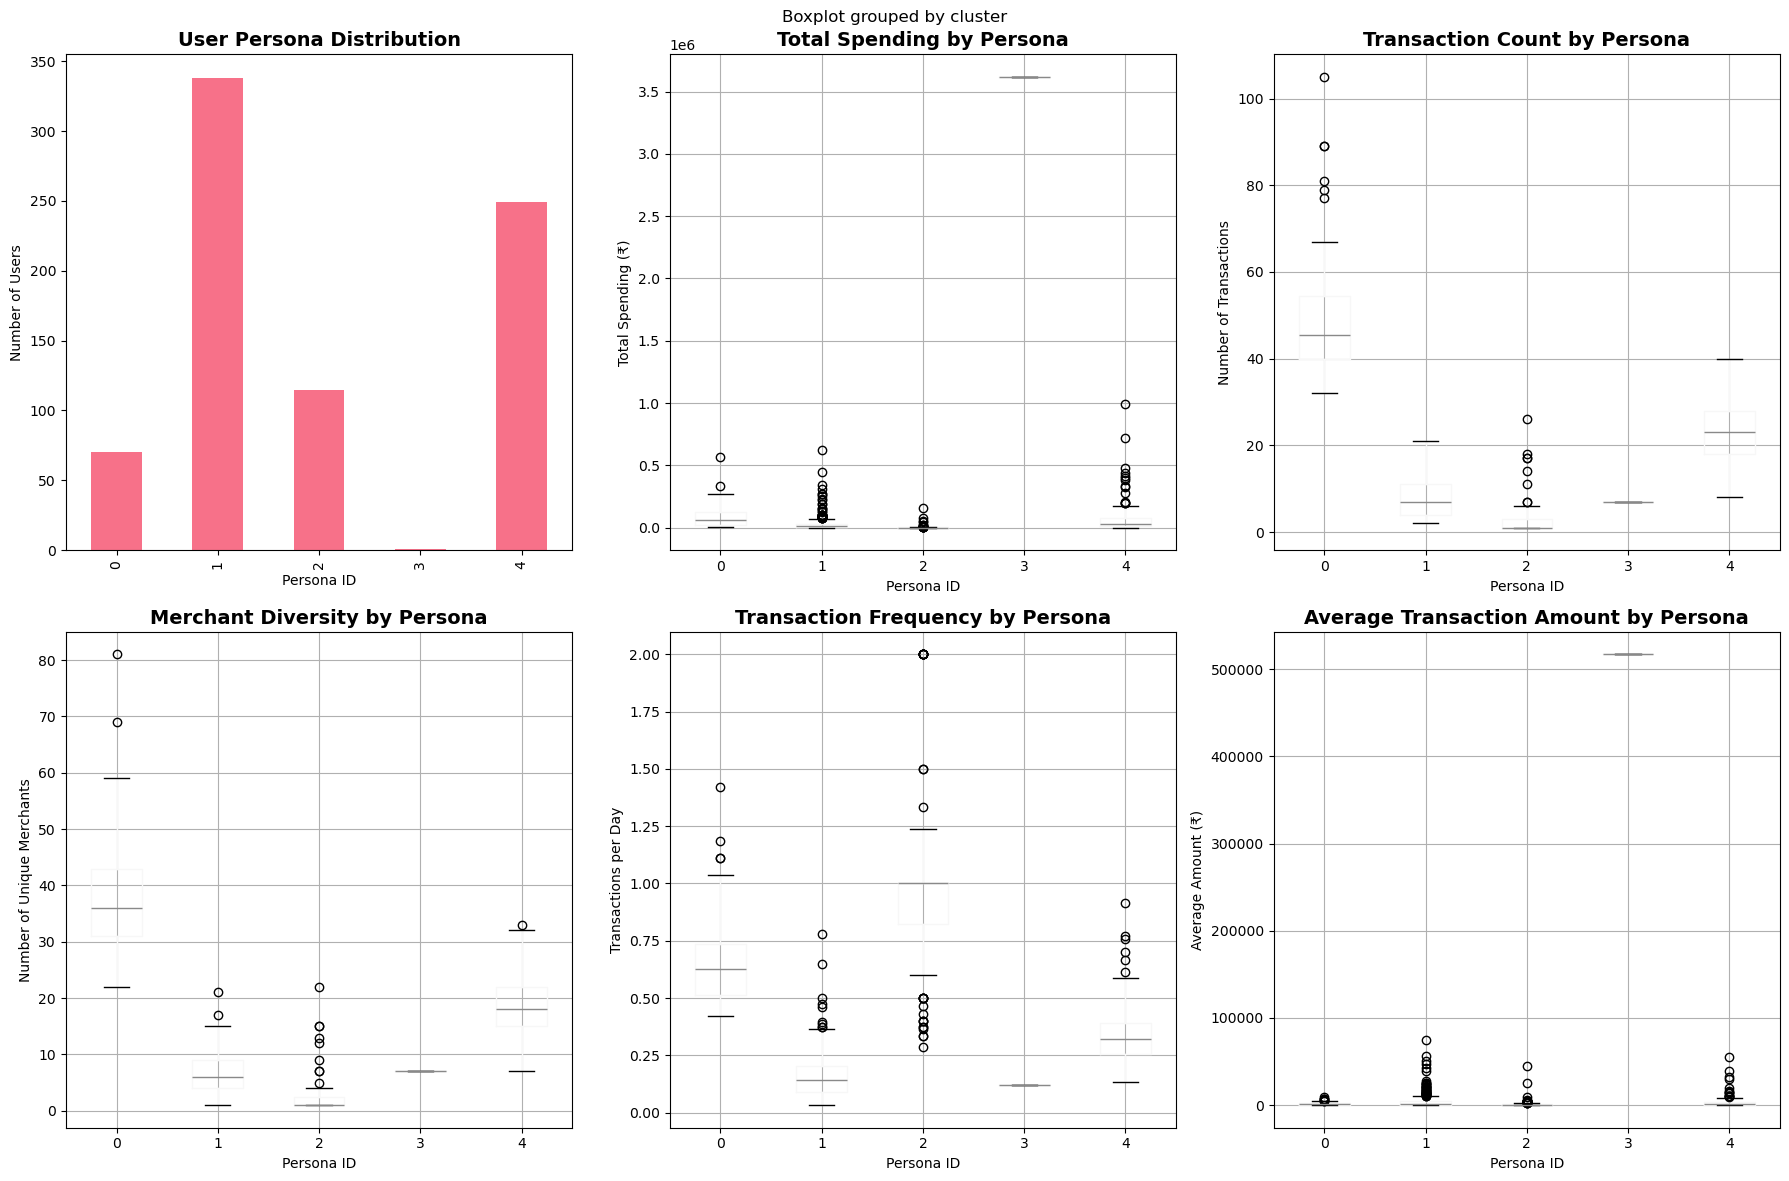


🏷️ Suggested Persona Names:
  Persona 1: High-Value Frequent Shoppers
  Persona 2: Moderate Shoppers
  Persona 3: Frequent Loyal Shoppers
  Persona 4: High-Value Occasional Shoppers
  Persona 5: Moderate Shoppers


In [19]:
# Visualize user personas
if df is not None and len(df) > 0 and 'user_features' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Cluster size distribution
    cluster_sizes = user_features['cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('User Persona Distribution', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Persona ID')
    axes[0,0].set_ylabel('Number of Users')
    
    # Spending by persona
    user_features.boxplot(column='total_spent', by='cluster', ax=axes[0,1])
    axes[0,1].set_title('Total Spending by Persona', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Persona ID')
    axes[0,1].set_ylabel('Total Spending (₹)')
    
    # Transaction count by persona
    user_features.boxplot(column='txn_count', by='cluster', ax=axes[0,2])
    axes[0,2].set_title('Transaction Count by Persona', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Persona ID')
    axes[0,2].set_ylabel('Number of Transactions')
    
    # Merchant diversity by persona
    user_features.boxplot(column='unique_merchants', by='cluster', ax=axes[1,0])
    axes[1,0].set_title('Merchant Diversity by Persona', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Persona ID')
    axes[1,0].set_ylabel('Number of Unique Merchants')
    
    # Transaction frequency by persona
    user_features.boxplot(column='txn_frequency', by='cluster', ax=axes[1,1])
    axes[1,1].set_title('Transaction Frequency by Persona', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Persona ID')
    axes[1,1].set_ylabel('Transactions per Day')
    
    # Average amount by persona
    user_features.boxplot(column='avg_amount', by='cluster', ax=axes[1,2])
    axes[1,2].set_title('Average Transaction Amount by Persona', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Persona ID')
    axes[1,2].set_ylabel('Average Amount (₹)')
    
    plt.tight_layout()
    plt.show()
    
    # Persona naming based on characteristics
    print("\n🏷️ Suggested Persona Names:")
    
    persona_names = {}
    for cluster_id in range(n_clusters):
        cluster_users = user_features[user_features['cluster'] == cluster_id]
        
        avg_spending = cluster_users['total_spent'].mean()
        avg_frequency = cluster_users['txn_frequency'].mean()
        avg_merchants = cluster_users['unique_merchants'].mean()
        
        # Simple persona naming logic
        if avg_spending > user_features['total_spent'].quantile(0.8):
            if avg_frequency > user_features['txn_frequency'].quantile(0.7):
                name = "High-Value Frequent Shoppers"
            else:
                name = "High-Value Occasional Shoppers"
        elif avg_frequency > user_features['txn_frequency'].quantile(0.8):
            if avg_merchants > user_features['unique_merchants'].quantile(0.7):
                name = "Frequent Diverse Shoppers"
            else:
                name = "Frequent Loyal Shoppers"
        elif avg_merchants > user_features['unique_merchants'].quantile(0.8):
            name = "Explorer Shoppers"
        else:
            if avg_spending < user_features['total_spent'].quantile(0.3):
                name = "Light Shoppers"
            else:
                name = "Moderate Shoppers"
        
        persona_names[cluster_id] = name
        print(f"  Persona {cluster_id + 1}: {name}")
    
    # Store persona names for future use
    user_features['persona_name'] = user_features['cluster'].map(persona_names)


In [20]:
# Summary of key findings and recommendations
print("📋 KEY FINDINGS & ML RECOMMENDATIONS")
print("=" * 60)

print("\n🎯 RECOMMENDATION SYSTEM STRATEGY:")
print("Based on the EDA analysis, here are the key insights and recommendations for building Jupiter's personalized reward recommendation system:")

print("\n1. 📊 DATA CHARACTERISTICS:")
if df is not None and len(df) > 0:
    print(f"   • Dataset size: {len(df):,} successful debit transactions")
    print(f"   • Users: {df['user_id'].nunique():,}")
    print(f"   • Merchants: {df['merchant_clean'].nunique():,}")
    print(f"   • Time span: {(df['transactiondatetime'].max() - df['transactiondatetime'].min()).days} days")
    
    if 'interaction_matrix' in locals():
        print(f"   • Matrix sparsity: {sparsity:.4f} ({sparsity*100:.2f}% empty)")

print("\n2. 🏪 MERCHANT INSIGHTS:")
print("   • High merchant concentration - top merchants dominate transaction volume")
print("   • Long tail of merchants with few transactions (cold start challenge)")
print("   • Merchant names need standardization for better recommendation accuracy")
print("   • Popular merchants offer best reward partnership opportunities")

print("\n3. 👥 USER BEHAVIOR PATTERNS:")
if 'user_stats' in locals():
    print(f"   • Average transactions per user: {user_stats['txn_count'].mean():.1f}")
    print(f"   • Average merchants per user: {user_stats['unique_merchants'].mean():.1f}")
    print("   • Clear user segmentation opportunities identified")
    print("   • Significant variation in spending patterns and frequency")

print("\n4. 📅 TEMPORAL PATTERNS:")
print("   • Clear day-of-week and hour-of-day patterns for contextual targeting")
print("   • Weekend vs weekday behavior differences")
print("   • Category-specific peak times for optimal reward timing")

print("\n5. 🎭 USER PERSONAS:")
if 'user_features' in locals() and 'persona_names' in locals():
    print("   • Successfully identified distinct user personas:")
    for cluster_id, name in persona_names.items():
        cluster_size = len(user_features[user_features['cluster'] == cluster_id])
        cluster_pct = cluster_size / len(user_features) * 100
        print(f"     - {name}: {cluster_pct:.1f}% of users")

print("\n🚀 RECOMMENDED ML APPROACH:")

print("\n1. 🔧 PREPROCESSING PIPELINE:")
print("   • Implement merchant name standardization (fuzzy matching, NER)")
print("   • Create temporal features (hour, day_of_week, seasonality)")
print("   • Engineer user behavior features (frequency, diversity, spending patterns)")
print("   • Handle cold start users with demographic/contextual features")

print("\n2. 🤖 MODEL ARCHITECTURE:")
if 'sparsity' in locals():
    if sparsity > 0.99:
        print("   • HYBRID APPROACH (Content + Collaborative):")
        print("     - Content-based filtering as primary method")
        print("     - Collaborative filtering for users with sufficient history")
        print("     - Matrix factorization for implicit feedback")
    elif sparsity > 0.95:
        print("   • COLLABORATIVE FILTERING with enhancements:")
        print("     - Matrix factorization (SVD, NMF)")
        print("     - Deep learning approaches (autoencoders)")
        print("     - Ensemble methods")
    else:
        print("   • TRADITIONAL COLLABORATIVE FILTERING:")
        print("     - Neighborhood-based methods")
        print("     - Matrix factorization")
        print("     - Deep learning approaches")

print("\n3. 🎯 CONTEXTUAL FEATURES:")
print("   • Time-of-day for contextual recommendations")
print("   • Day-of-week patterns for scheduling")
print("   • User persona for targeted reward types")
print("   • Recent transaction patterns for recency weighting")
print("   • Category preferences for relevant rewards")

print("\n4. 📱 IMPLEMENTATION STRATEGY:")
print("   • Phase 1: Content-based recommendations using categories and merchants")
print("   • Phase 2: Hybrid system incorporating collaborative filtering")
print("   • Phase 3: Real-time contextual recommendations with temporal features")
print("   • Phase 4: Advanced personalization with deep learning")

print("\n5. 🎲 RECOMMENDATION TYPES:")
print("   • Merchant-specific rewards (BookMyShow, Swiggy, Uber)")
print("   • Category-based rewards (food, entertainment, travel)")
print("   • Temporal rewards (Friday night dining, weekend shopping)")
print("   • Persona-specific reward bundles")

print("\n6. 📏 EVALUATION METRICS:")
print("   • Click-through rate (CTR) on recommendations")
print("   • Conversion rate (reward redemption)")
print("   • User engagement metrics")
print("   • Revenue impact from reward partnerships")
print("   • User satisfaction scores")

print("\n7. 🔄 CONTINUOUS IMPROVEMENT:")
print("   • A/B testing framework for recommendation algorithms")
print("   • Real-time feedback incorporation")
print("   • Periodic model retraining")
print("   • Cold start handling for new users/merchants")

print("\n✅ NEXT STEPS:")
print("   1. Implement merchant name standardization")
print("   2. Build content-based recommendation baseline")
print("   3. Develop user feature engineering pipeline")
print("   4. Create evaluation framework")
print("   5. Design A/B testing infrastructure")
print("   6. Integrate with Jupiter Store and notification systems")

print("\n" + "=" * 60)
print("🎯 EDA ANALYSIS COMPLETE - Ready for ML Model Development!")
print("=" * 60)


📋 KEY FINDINGS & ML RECOMMENDATIONS

🎯 RECOMMENDATION SYSTEM STRATEGY:
Based on the EDA analysis, here are the key insights and recommendations for building Jupiter's personalized reward recommendation system:

1. 📊 DATA CHARACTERISTICS:
   • Dataset size: 12,189 successful debit transactions
   • Users: 773
   • Merchants: 8,617
   • Time span: 79 days
   • Matrix sparsity: 0.9687 (96.87% empty)

2. 🏪 MERCHANT INSIGHTS:
   • High merchant concentration - top merchants dominate transaction volume
   • Long tail of merchants with few transactions (cold start challenge)
   • Merchant names need standardization for better recommendation accuracy
   • Popular merchants offer best reward partnership opportunities

3. 👥 USER BEHAVIOR PATTERNS:
   • Average transactions per user: 15.8
   • Average merchants per user: 12.7
   • Clear user segmentation opportunities identified
   • Significant variation in spending patterns and frequency

4. 📅 TEMPORAL PATTERNS:
   • Clear day-of-week and hour-